#### Aim
_classify texts written by students into three categories: efective, adequate, ineffective_ <br>
_eval method: multi class log loss_

In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
sns.set_palette('Spectral_r')

In [4]:
RANDOM_SEED = 22

#### Initial steps 
Remarks:
- _'discourse effectiveness' is the target variable_ 
    - somewhat unbalanced
        - adequate: .57
        - effective: .25
        - ineffective: .17
<br>
<br>
- _'discourse_id' unique for each entry_

- _'essay_id' denotes the context; text can be loaded in the for more inherent information_
    - _seems to be normally distributed, each essay appearing ~ 10x_
<br>
<br>
- _'discourse_type' is a catgorical feature with 7 unique categories: 
    - _'Rebuttal', 'Counterclaim', 'Lead', 'Concluding Statement', 'Position',
       'Claim', 'Evidence'_
    - Frequency: 
        'Rebuttal': 0.03383653, 
        'Counterclaim': 0.04822521, 
        'Lead': 0.0623147 , 
        'Concluding Statement': 0.09114647, 
        'Position': 0.10945192,
        __'Claim' : 0.32577179__, 
        __'Evidence': 0.32925337__

<br>
<br>
- TODO: _'discourse_text'_
<br>
- TODO: _'essay_text'_


<br>
<br>

- Questions to think about: 
    - What makes an argument effective? And, conversely one ineffective?
    - Does the degree of formalness matter? What kind of language is used?
    - Is it relatedness to the topic at hand?
    
    - Why does _discourse type_ matter?
         

worth checking out: ECDF of syll_per_words for each target label <br>
is it significant?
not sure

####  Data reading, info, describe


In [5]:
train_path = "train.csv"
test_path =  "test.csv"

In [6]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train['essay_text'] = train['essay_id'].apply(lambda x: open(f"train/{x}.txt", encoding='utf-8').read())
test['essay_text'] = test['essay_id'].apply(lambda x: open(f"test/{x}.txt", encoding='utf-8').read())

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
 5   essay_text               36765 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


In [8]:
train.describe().T

,count,unique,top,freq
discourse_id,36765,36765,0013cc385424,1
essay_id,36765,4191,91B1F82B2CF1,23
discourse_text,36765,36691,Summer projects should be student-designed,14
discourse_type,36765,7,Evidence,12105
discourse_effectiveness,36765,3,Adequate,20977
essay_text,36765,4191,Many people may think that attending school on...,23


In [9]:
test.describe().T

,count,unique,top,freq
discourse_id,10,10,a261b6e14276,1
essay_id,10,1,D72CB1C11673,10
discourse_text,10,10,Making choices in life can be very difficult. ...,1
discourse_type,10,5,Claim,4
essay_text,10,1,Making choices in life can be very difficult. ...,10


In [10]:
train.head(25)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,"Hi, i'm Isaac, i'm going to be writing about h..."
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,Limiting the usage of cars has personal and pr...


In [11]:
train.discourse_text

0        Hi, i'm Isaac, i'm going to be writing about h...
1        On my perspective, I think that the face is a ...
2        I think that the face is a natural landform be...
3        If life was on Mars, we would know by now. The...
4        People thought that the face was formed by ali...
                               ...                        
36760    For many people they don't like only asking on...
36761    also people have different views and opinions ...
36762    Advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object

#### Essay_id

In [12]:
subset = train.essay_id.value_counts()
subset

91B1F82B2CF1    23
4CA37D113612    23
900A879708F0    23
A7EC6F462F8B    22
DECAE402BB38    22
                ..
AB02689C1A9B     1
FFFF80B8CC2F     1
377548575048     1
5E85F1FB4E22     1
9706F8E7D534     1
Name: essay_id, Length: 4191, dtype: int64

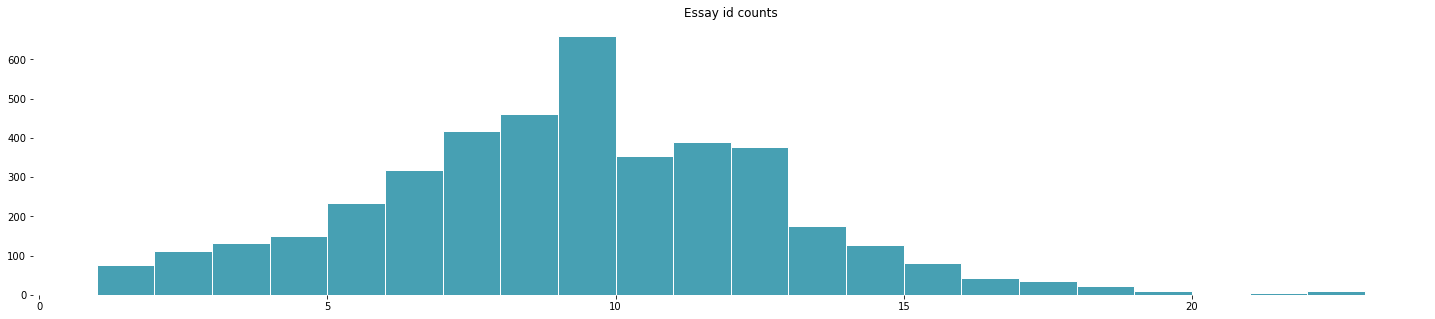

In [13]:
plt.figure(figsize = (25,5))
plt.hist(subset.values, rwidth = 1, bins = 22, align='mid', edgecolor = 'white')
plt.title('Essay id counts')
plt.box(False)
plt.show()

The majority of essays appear ~10 times.


#### Discourse effectiveness

In [14]:
subset = train.discourse_effectiveness.value_counts(ascending=True)
subset = subset / len(train)

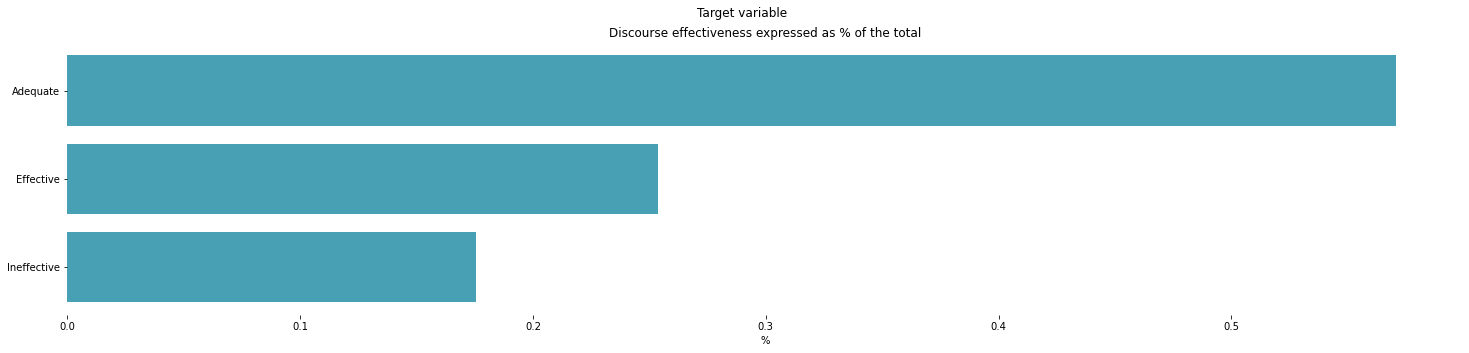

In [15]:
plt.figure(figsize = (25,5))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse effectiveness expressed as % of the total')
plt.suptitle('Target variable')
plt.xlabel('%')
plt.box(False)
plt.show()

In [16]:
subset.values

array([0.17576499, 0.25366517, 0.57056984])

So it it somewhat unbalanced.

In [17]:
len(train) - train.discourse_text.nunique() 

74

There are 74 instances where one or more _discourse_texts_ is repeated.

#### Discourse_text 

In [18]:
subset = train.discourse_type.value_counts(ascending=True)
subset = subset / len(train)

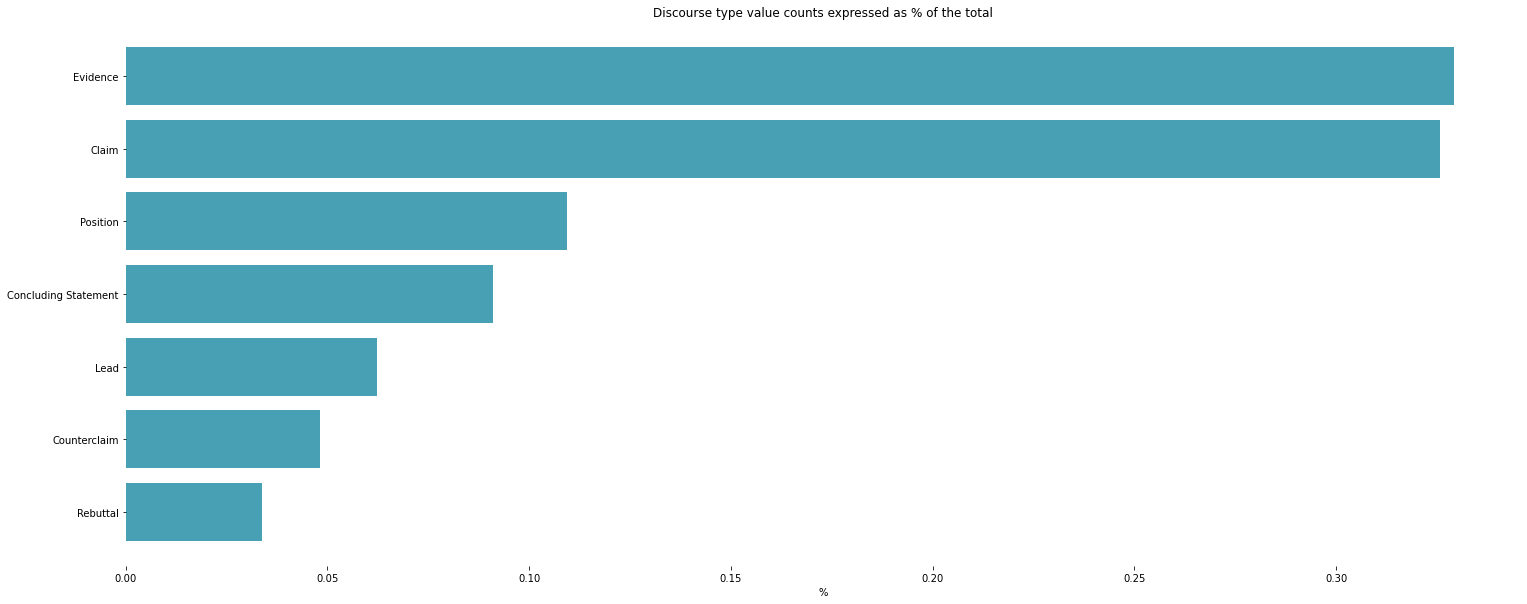

In [19]:
plt.figure(figsize = (25,10))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse type value counts expressed as % of the total')
plt.xlabel('%')
plt.box(False)
plt.show()

In [20]:
subset.values

array([0.03383653, 0.04822521, 0.0623147 , 0.09114647, 0.10945192,
       0.32577179, 0.32925337])

In [21]:
subset = train.loc[train.discourse_effectiveness == 'Adequate'].discourse_type
subset = sorted(subset)

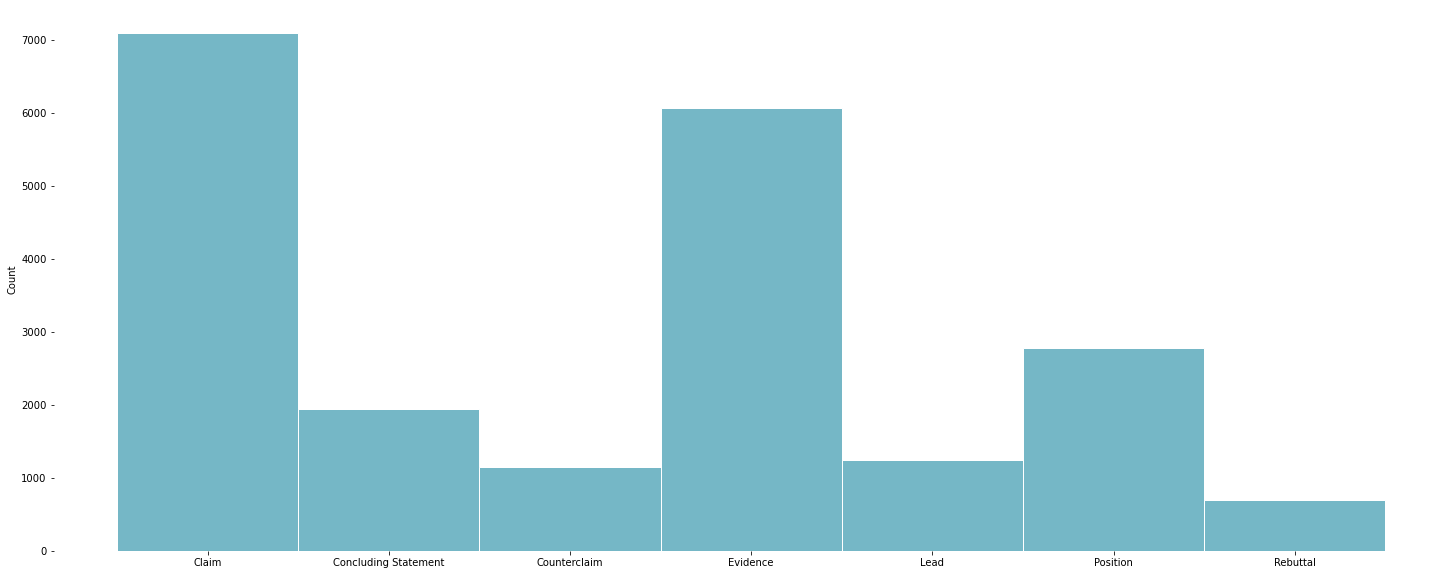

In [22]:
plt.figure(figsize = (25,10))
sns.histplot(subset, edgecolor = 'white')
plt.box(False)

In [23]:
subset = train.discourse_text.str.len()
subset

0        317
1        210
2        105
3        362
4        101
        ... 
36760    126
36761     57
36762    121
36763    439
36764     67
Name: discourse_text, Length: 36765, dtype: int64

#### Discourse text 2

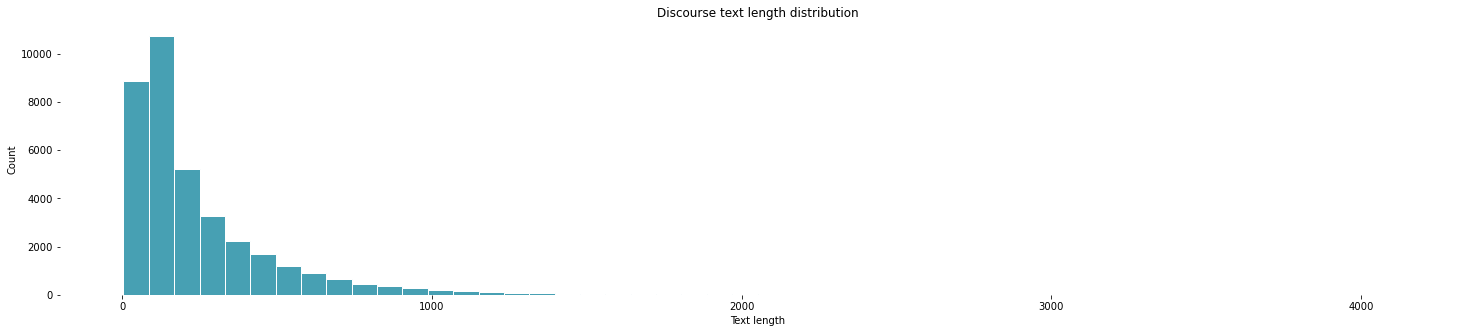

In [24]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text length distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.box(False)
plt.show()

In [25]:
subset = train.discourse_text.str.split(' ').map(len)
subset

0        68
1        42
2        22
3        73
4        19
         ..
36760    22
36761    10
36762    24
36763    82
36764    12
Name: discourse_text, Length: 36765, dtype: int64

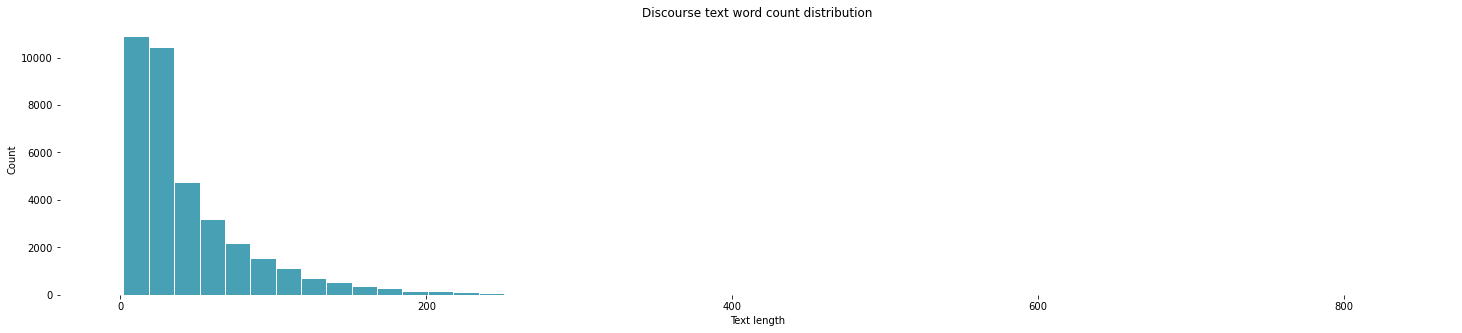

In [26]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text word count distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.box(False)
plt.show()

####  Why and how does _discourse type_ matter?

In [27]:
train[train.loc[:, 'discourse_type'] == 'Lead']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,Limiting the usage of cars has personal and pr...
20,ed7e62a18bad,00BD97EA4041,Should computers read the emotional expression...,Lead,Adequate,Should computers read the emotional expression...
33,ed3a833a2f49,013B9AA6B9DB,What is that thing on Mars?,Lead,Adequate,"What is that thing on Mars?\n\nWell, some peop..."
44,55f4bc9b664b,0158970BC5D2,Students around the world are forgetting more ...,Lead,Adequate,Students around the world are forgetting more ...
...,...,...,...,...,...,...
36699,c42e3ed1626b,FD8A9514C8BC,Not too long ago I got into a disagreement wit...,Lead,Adequate,Not too long ago I got into a disagreement wit...
36708,d934843f1543,FDF0AEEB14C3,Going to school everyday can be difficult for ...,Lead,Effective,Going to school everyday can be difficult for ...
36723,bf5f089e19df,FE3CA06DDCA1,Why is it when someone asks you for advice the...,Lead,Ineffective,Why is it when someone asks you for advice the...
36730,cea348b818a9,FEF42864AE28,"During a long day at school, have you ever tho...",Lead,Effective,"During a long day at school, have you ever tho..."


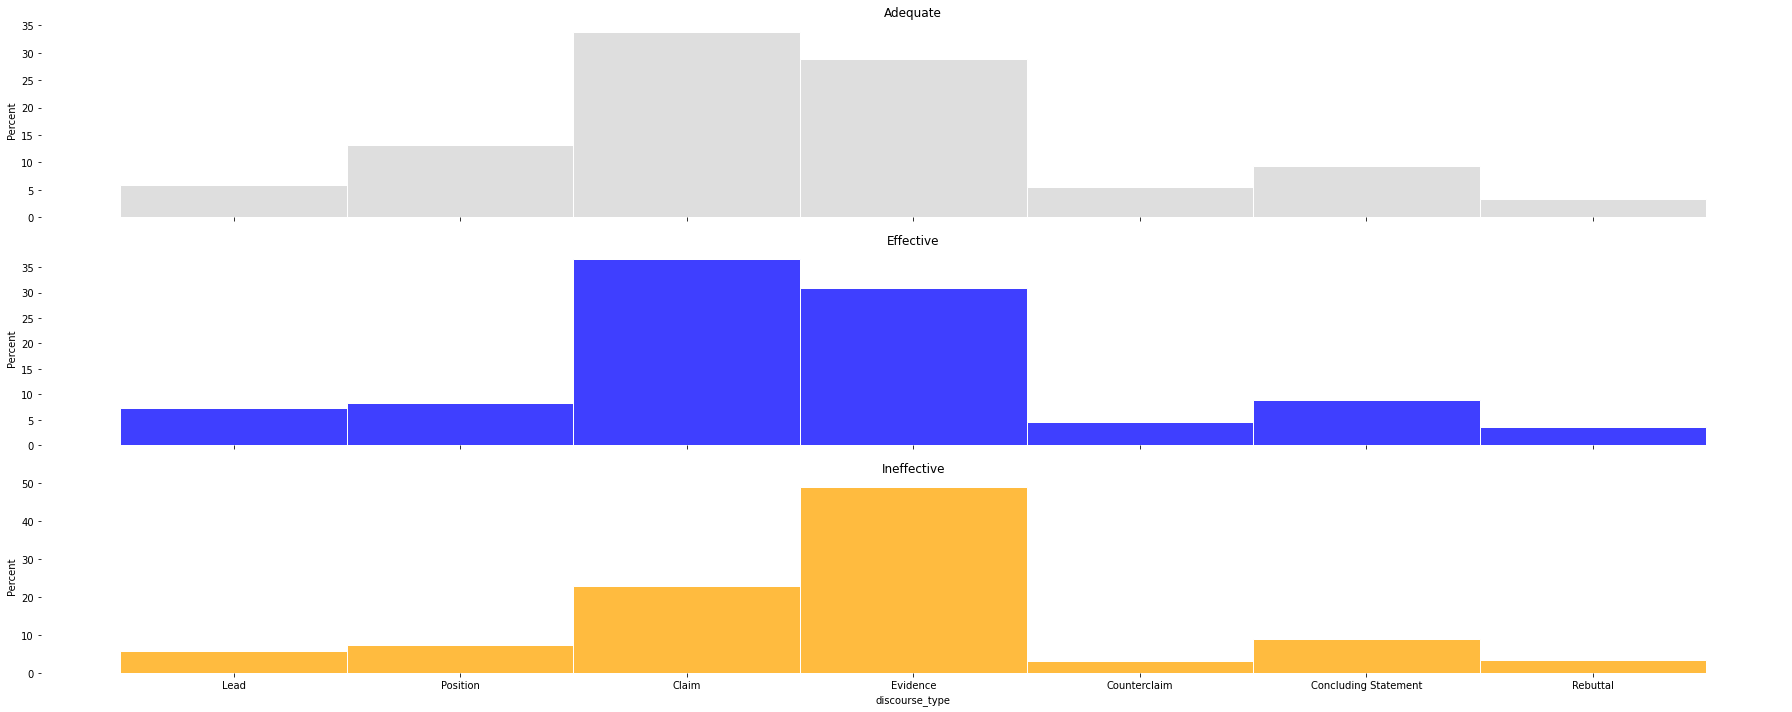

In [28]:
fig,axs = plt.subplots(nrows = train.discourse_effectiveness.nunique(), ncols = 1,figsize= (25,10), sharex = True)

colors = ['lightgray', 'blue', 'orange']

for idx, eff in enumerate(['Adequate', 'Effective', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].discourse_type, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white', color = colors[idx]).set_title(eff)
    axs[idx].set_frame_on(False)

plt.tight_layout()
plt.show()



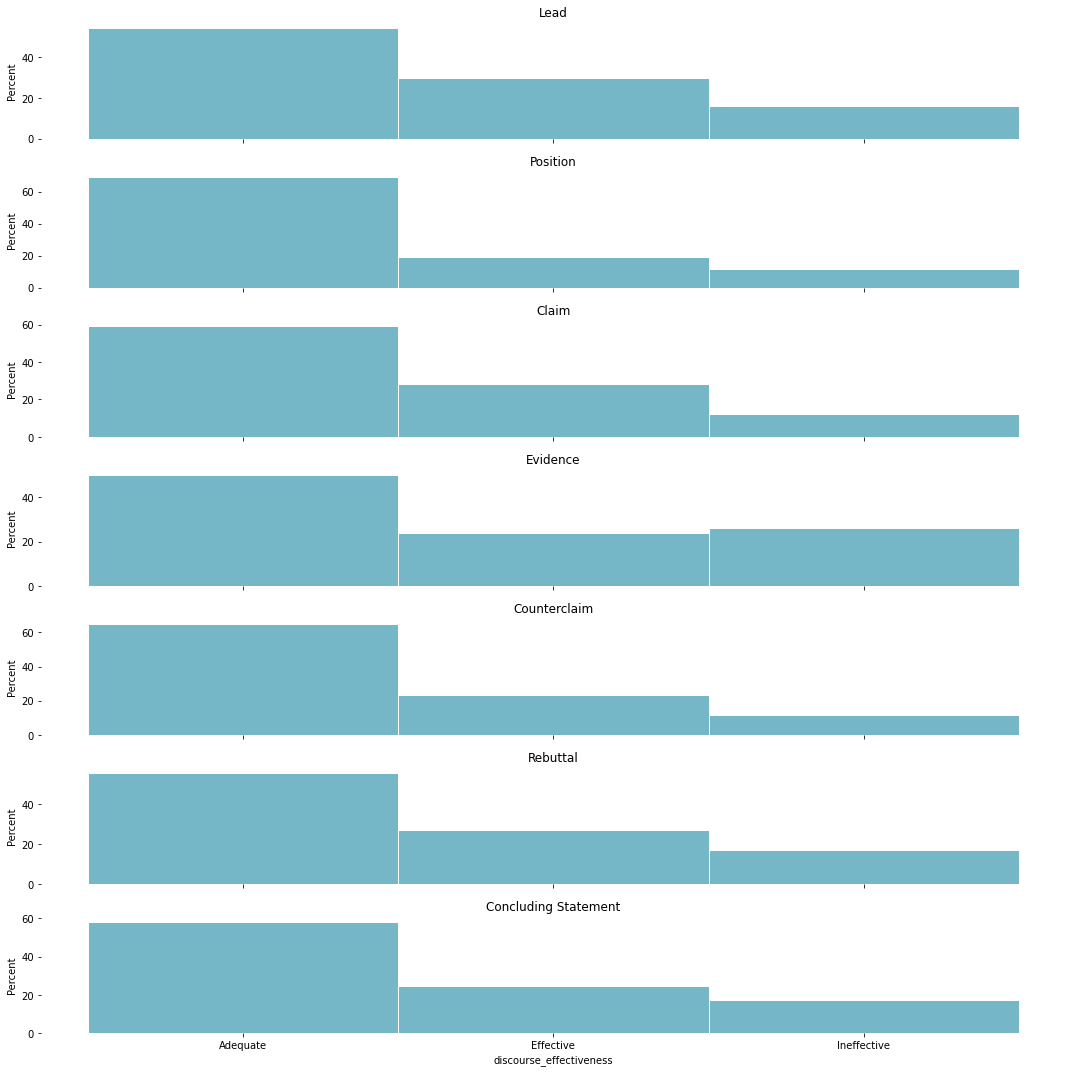

In [29]:
fig, axs = plt.subplots(nrows = 7, ncols = 1, figsize= (15,15), sharex = True)
for idx, eff in enumerate(train.discourse_type.unique()):
    sns.histplot(train[train.loc[:, 'discourse_type'] == eff].discourse_effectiveness, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.show()

In [30]:
np.unique(train.groupby('discourse_text').discourse_type.value_counts().values, return_counts=True)

(array([ 1,  2,  3,  4,  5,  7, 14]),
 array([36656,    30,     5,     2,     1,     1,     1]))

In [31]:
train.discourse_text.nunique()

36691

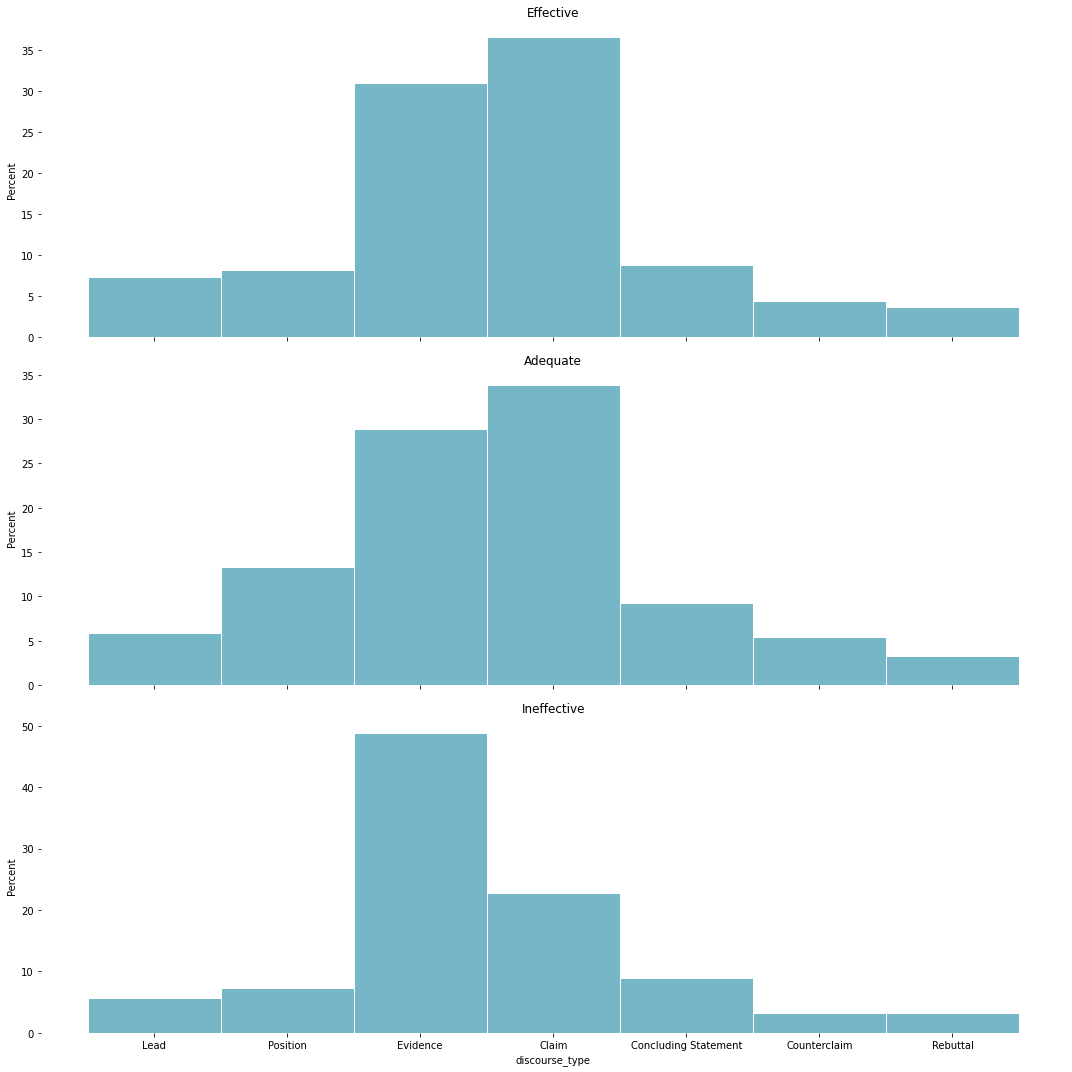

In [32]:
#### TODO: Needs interpretation

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (15,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].discourse_type, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.show()



In [33]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import wordcloud as wc
from itertools import chain

In [34]:
STOPWORDS = set(stopwords.words('english'))

In [35]:
?wc.WordCloud

Init signature:
wc.WordCloud(
    font_path=None,
    width=400,
    height=200,
    margin=2,
    ranks_only=None,
    prefer_horizontal=0.9,
    mask=None,
    scale=1,
    color_func=None,
    max_words=200,
    min_font_size=4,
    stopwords=None,
    random_state=None,
    background_color='black',
    max_font_size=None,
    font_step=1,
    mode='RGB',
    relative_scaling='auto',
    regexp=None,
    collocations=True,
    colormap=None,
    normalize_plurals=True,
    contour_width=0,
    contour_color='black',
    repeat=False,
    include_numbers=False,
    min_word_length=0,
    collocation_threshold=30,
)
Docstring:     
Word cloud object for generating and drawing.

Parameters
----------
font_path : string
    Font path to the font that will be used (OTF or TTF).
    Defaults to DroidSansMono path on a Linux machine. If you are on
    another OS or don't have this font, you need to adjust this path.

width : int (default=400)
    Width of the canvas.

height : int (defaul

In [36]:
STOPWORDS.update(['people', 'would','student', 'students', 'school'])

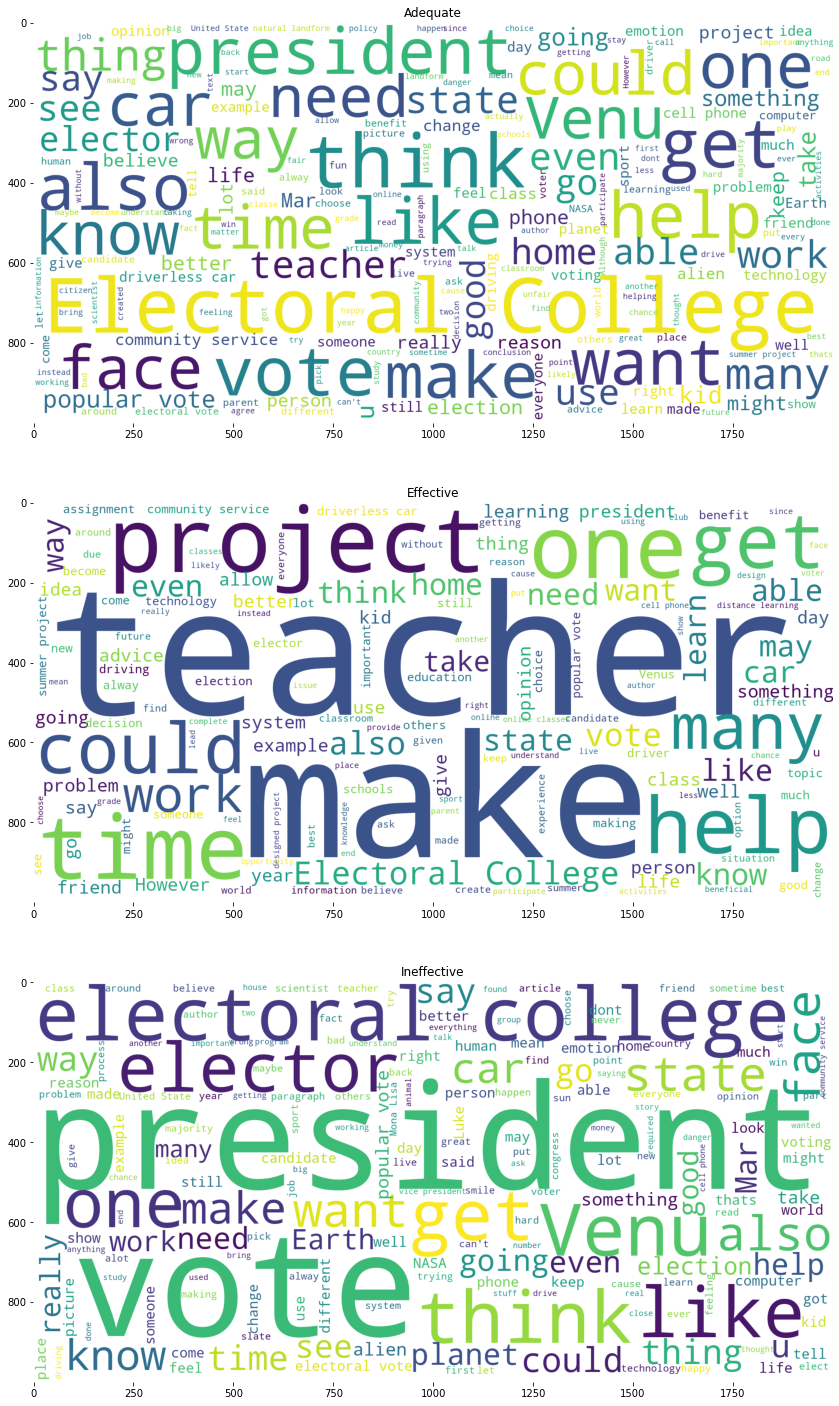

In [37]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (25,25))

for idx, label in enumerate(['Adequate', 'Effective', 'Ineffective']):
    subset = train.loc[train['discourse_effectiveness'] == label,:].discourse_text
    subset = ' '.join(subset)
    cloud = wc.WordCloud(background_color = 'white', scale = 5, stopwords=STOPWORDS, max_words=250).generate(subset)
    axs[idx].imshow(cloud)
    axs[idx].set_title(label)
    axs[idx].set_frame_on(False)
    # tokenized_subset = subset.map(word_tokenize)
    # merged_subset = list(chain(*tokenized_subset.to_list()))
    # cloud = wc.WordCloud(token)    


plt.box(False)
plt.show()

One thing that stood out at a first glance is that in the ineffective class named entities have been not capitalized.
Also, it feels like there are more grammar errors. (?)

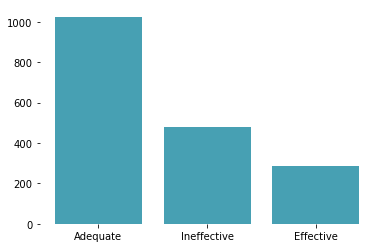

In [38]:
subset = train.loc[train.discourse_text.str.contains('Venus'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

Ineffective    2
Name: discourse_effectiveness, dtype: int64


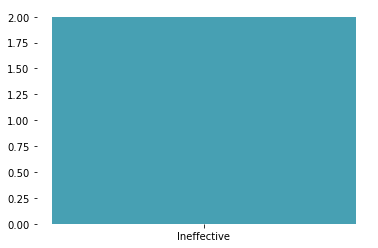

In [39]:
subset = train.loc[train.discourse_text.str.contains('Venu '),:].discourse_effectiveness.value_counts()
print(subset)
plt.bar(x = subset.index, height = subset.values)
plt.box(False)


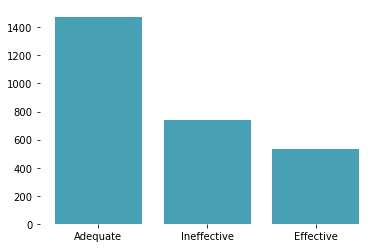

In [40]:
subset = train.loc[train.discourse_text.str.contains('president'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

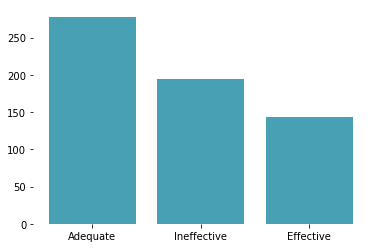

In [41]:
subset = train.loc[train.discourse_text.str.contains('President'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

In [42]:
from spylls.hunspell import Dictionary
from string import punctuation
import re
import contractions
DICTIONARY = Dictionary.from_files('en_US')
PUNCTUATIONS = set(list(punctuation))
PUNCTUATIONS.update("`")
PUNCTUATIONS.update("'")

In [43]:
PUNCTUATIONS

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [44]:
DICTIONARY

In [45]:
CONTRACTIONS = contractions.contractions_dict
CONTRACTIONS["It'll"] = "It will"
CONTRACTIONS = {key.capitalize(): value for key, value in CONTRACTIONS.items()}


def check_word(token):
    if DICTIONARY.lookup(token):
        return 1
    else:
        return 0

def replace_contractions(text):

    
    for key, value in CONTRACTIONS.items():
        # Upper-case
        text = text.replace(key, value)
        # Lower-case 
        text = text.replace(key.lower(), value.lower())

    # Remove possesives as well 
    text = text.replace("'s", "")

    # Remove unnecessary whitespaces
    text = re.sub(' +', ' ', text)
    
    return text 

NOT_MISTAKES = ['landform', 'driverless']

def remove_empty_tokens(list_of_tokens):
    list_of_tokens = list(filter(None, list_of_tokens))
    return list_of_tokens

def check_in_dictionary(sentences):

    # If the contraction can be removed, than it means it's correct; consequently, only possibly incorrect words remain

    tokenized_sentences = word_tokenize(sentences)
    correct_tokens = [check_word(token) if (token not in PUNCTUATIONS) and (token not in NOT_MISTAKES)  else 1 for token in tokenized_sentences]

    return correct_tokens

def get_incorrect_indices(correct_word_list):
    return [idx for idx, value in enumerate(correct_word_list) if not value]

def get_incorrect_words(words_list, indices):
    return [words_list[idx] for idx in indices if words_list[idx] ]


In [46]:
train 

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,Some people may ask multiple people for advice...
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,Some people may ask multiple people for advice...
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate,Some people may ask multiple people for advice...
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective,Some people may ask multiple people for advice...


In [47]:
train['text_'] = train.discourse_text.map(replace_contractions)

In [48]:
train['tokenized_sentences'] = train.text_.map(word_tokenize)

In [49]:
# train['tokenized_sentences'] = train.tokenized_sentences.map(remove_empty_tokens)

In [50]:
train['correct_list'] = train.text_.map(check_in_dictionary)

In [51]:
train['incorrect_indices'] = train.correct_list.map(get_incorrect_indices)

In [52]:
train['incorrect_words'] = train.apply(lambda x: get_incorrect_words(x.tokenized_sentences, x.incorrect_indices), axis = 1)

In [53]:
train['incorrect_words_len'] = train.incorrect_words.map(len)

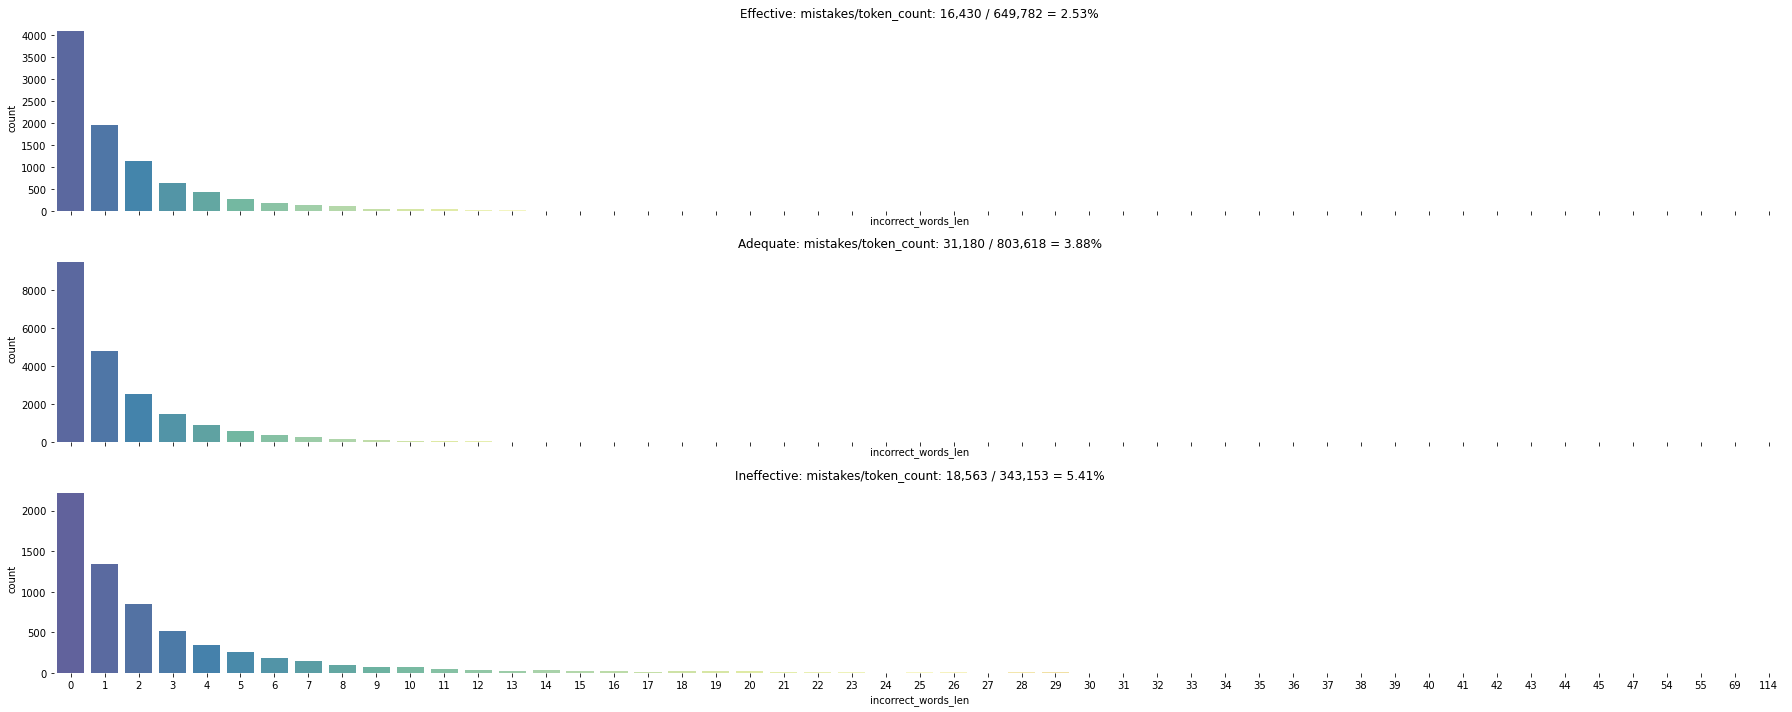

In [54]:
fig, axs = plt.subplots(nrows = 3 , ncols = 1, figsize= (25,10), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    subset = train.loc[train.discourse_effectiveness == eff].incorrect_words_len
    subset_sum = subset.sum()
    total_token_count = train.loc[train.discourse_effectiveness == eff].tokenized_sentences.map(len).sum()
    sns.countplot(x = subset, ax = axs[idx], palette = 'Spectral_r').set_title(f"{eff}: mistakes/token_count: {subset_sum:,} / {total_token_count:,} = {subset_sum/total_token_count:.2%}") 
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.box(False)
plt.show()


#### WORDCLOUD for flagged mistakes/typos

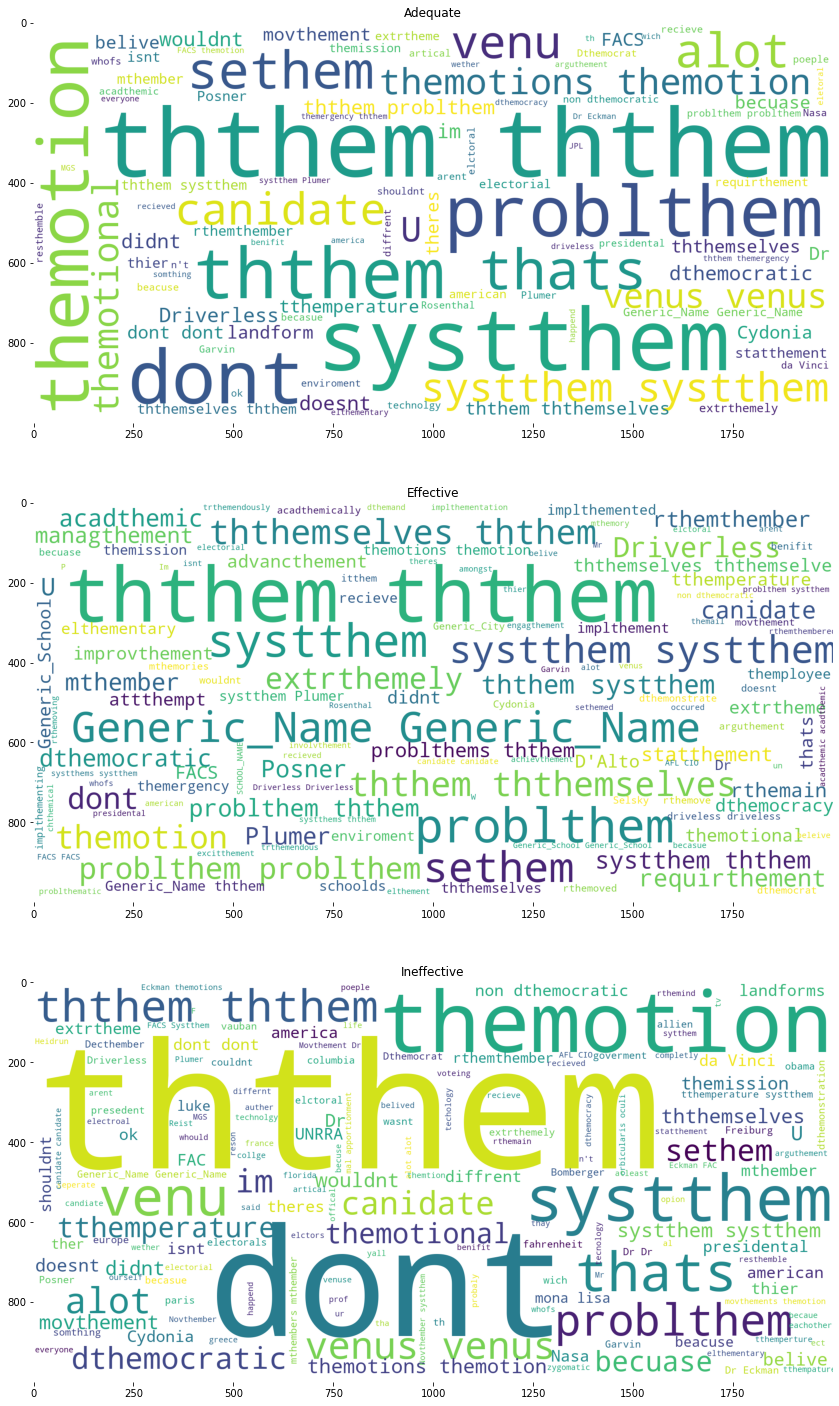

In [55]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (25,25))

for idx, label in enumerate(['Adequate', 'Effective', 'Ineffective']):
    subset = train.loc[train['discourse_effectiveness'] == label,:].incorrect_words.map(' '.join)
    subset = ' '.join(subset)
    cloud = wc.WordCloud(background_color = 'white', scale = 5, stopwords=STOPWORDS, max_words=500).generate(subset)
    axs[idx].imshow(cloud)
    axs[idx].set_title(label)
    axs[idx].set_frame_on(False)
    # tokenized_subset = subset.map(word_tokenize)
    # merged_subset = list(chain(*tokenized_subset.to_list()))
    # cloud = wc.WordCloud(token)    


plt.box(False)
plt.show()

#### NER
TODO: Named entity recognition, check if capitalized

#### Relative position of argument in essay

In [56]:
def find_relative_position(argument, essay):
    essay_length = len(essay)
    split_essay = essay.split(argument.strip())
    
    if split_essay[0] == essay:
        return (0,0)

    if split_essay ==  ['', '']:
        return (0,1)
    
    if split_essay[0] == '':
        return (0, (essay_length - len(split_essay[1])) / essay_length)
    
    try:
        if split_essay[1] == '':  
            return ((essay_length - len(split_essay[0])) / essay_length, 1)
    except:
        return None
    else:
        return (
            len(split_essay[0]) / essay_length,
            (len(split_essay[0]) + len(argument)) / essay_length)

In [57]:
find_relative_position(argument = 'exmachin', essay = 'deusexmachina')

(0.3076923076923077, 0.9230769230769231)

In [58]:
"alma".split('alma')

['', '']

In [59]:
from unidecode import unidecode

In [60]:
unidecode(train.essay_text.iloc[0])

'Hi, i\'m Isaac, i\'m going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn\'t know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I\'ll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It\'s not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point. In all that they\'re saying, its probably a natural landf

In [61]:
train.essay_text.iloc[0]

'Hi, i\'m Isaac, i\'m going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn\'t know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I\'ll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It\'s not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point. In all that they\'re saying, its probably a natural landf

In [62]:
train['relative_position'] = train.apply(lambda x: find_relative_position(argument = x.discourse_text, essay = x.essay_text), axis = 1)

In [63]:
subset_of_interest = train.loc[train.relative_position.isna()]
subset_of_interest

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_,tokenized_sentences,correct_list,incorrect_indices,incorrect_words,incorrect_words_len,relative_position


In [64]:
subset_of_interest.discourse_text

Series([], Name: discourse_text, dtype: object)

In [65]:
subset_of_interest.essay_text

Series([], Name: essay_text, dtype: object)

#### SLANG

#### Common english words

#### Syllables

In [66]:
from hyphenate import hyphenate_word
from nltk.tokenize import sent_tokenize

In [67]:
train['sentences'] = train.discourse_text.map(sent_tokenize)
train['words'] = train.sentences.apply(lambda sentences: list(chain(*[word_tokenize(sentence) for sentence in sentences])))
train['words'] = train.words.apply(lambda tokens: [token for token in tokens if (token not in PUNCTUATIONS and token != '')])
train['syllables'] = train.words.apply(lambda tokens: list(chain(*[hyphenate_word(token) for token in tokens])))

In [68]:
train['sent_count'] = train.sentences.map(len)
train['word_count'] = train.words.map(len)
train['syll_count'] = train.syllables.map(len)

train['words_per_sentences'] = train['sent_count'] / train['word_count']
train['syll_per_sentences'] =  train['sent_count'] / train['syll_count'] 
train['syll_per_words'] = train['word_count'] / train['syll_count']

In [69]:
train

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_,tokenized_sentences,correct_list,incorrect_indices,...,relative_position,sentences,words,syllables,sent_count,word_count,syll_count,words_per_sentences,syll_per_sentences,syll_per_words
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","Hi, i am Isaac, i am going to be writing about...","[Hi, ,, i, am, Isaac, ,, i, am, going, to, be,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],...,"(0, 0.17400881057268722)","[Hi, i'm Isaac, i'm going to be writing about ...","[Hi, i, 'm, Isaac, i, 'm, going, to, be, writi...","[Hi, i, 'm, Isaac, i, 'm, go, ing, to, be, wri...",3,70,84,0.042857,0.035714,0.833333
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","On my perspective, I think that the face is a ...","[On, my, perspective, ,, I, think, that, the, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[15],...,"(0.17455947136563876, 0.29019823788546256)","[On my perspective, I think that the face is a...","[On, my, perspective, I, think, that, the, fac...","[On, my, per, spec, tive, I, think, that, the,...",2,42,53,0.047619,0.037736,0.792453
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...",I think that the face is a natural landform be...,"[I, think, that, the, face, is, a, natural, la...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[19],...,"(0.2907488986784141, 0.348568281938326)",[I think that the face is a natural landform b...,"[I, think, that, the, face, is, a, natural, la...","[I, think, that, the, face, is, a, nat, ur, al...",1,21,27,0.047619,0.037037,0.777778
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","If life was on Mars, we would know by now. The...","[If, life, was, on, Mars, ,, we, would, know, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[41, 48, 50]",...,"(0.3491189427312775, 0.5484581497797357)","[If life was on Mars, we would know by now., T...","[If, life, was, on, Mars, we, would, know, by,...","[If, life, was, on, Mars, we, would, know, by,...",4,76,99,0.052632,0.040404,0.767677
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...",People thought that the face was formed by ali...,"[People, thought, that, the, face, was, formed...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",[8],...,"(0.5490088105726872, 0.6046255506607929)",[People thought that the face was formed by al...,"[People, thought, that, the, face, was, formed...","[Peo, ple, thought, that, the, face, was, form...",1,18,20,0.055556,0.050000,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,Some people may ask multiple people for advice...,For many people they do not like only asking o...,"[For, many, people, they, do, not, like, only,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],...,"(0.08082901554404145, 0.21139896373056996)",[For many people they don't like only asking o...,"[For, many, people, they, do, n't, like, only,...","[For, many, peo, ple, they, do, n't, like, onl...",1,22,31,0.045455,0.032258,0.709677
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,Some people may ask multiple people for advice...,also people have different views and opinions ...,"[also, people, have, different, views, and, op...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[],...,"(0.21243523316062177, 0.27150259067357513)",[also people have different views 

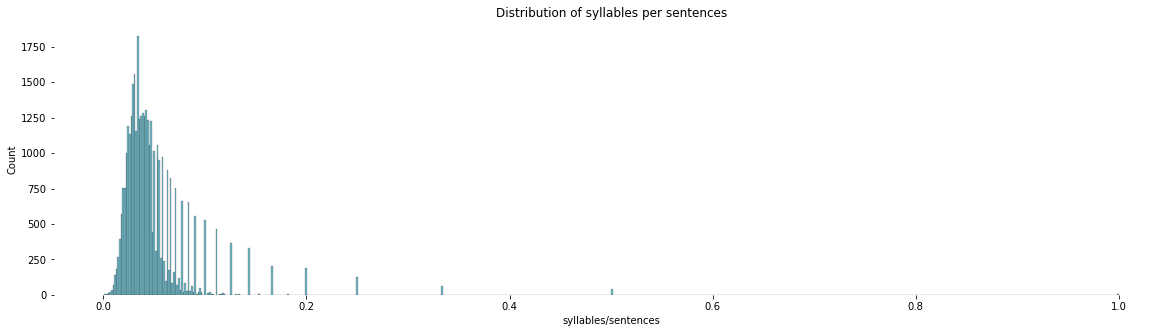

In [70]:
fig = plt.figure(figsize = (20,5))
sns.histplot(train.syll_per_sentences)
plt.title('Distribution of syllables per sentences')
plt.xlabel('syllables/sentences')
plt.ylabel('Count')
plt.box(False)
plt.show()

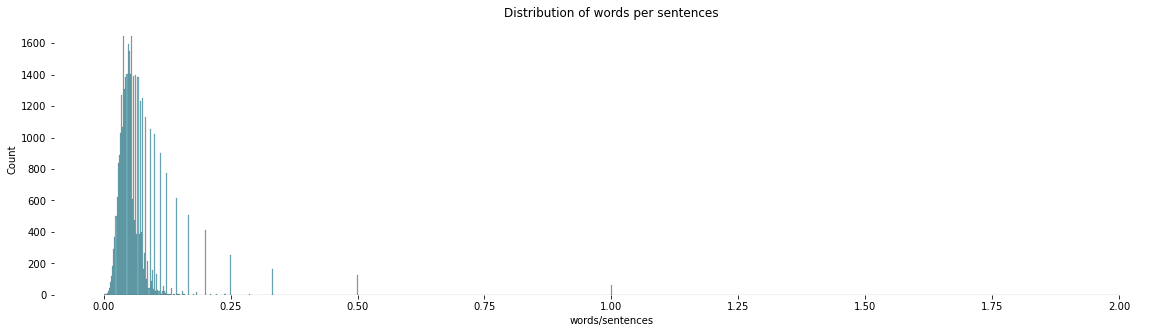

In [71]:
fig = plt.figure(figsize = (20,5))
sns.histplot(train.words_per_sentences)
plt.title('Distribution of words per sentences')
plt.xlabel('words/sentences')
plt.ylabel('Count')
plt.box(False)
plt.show()

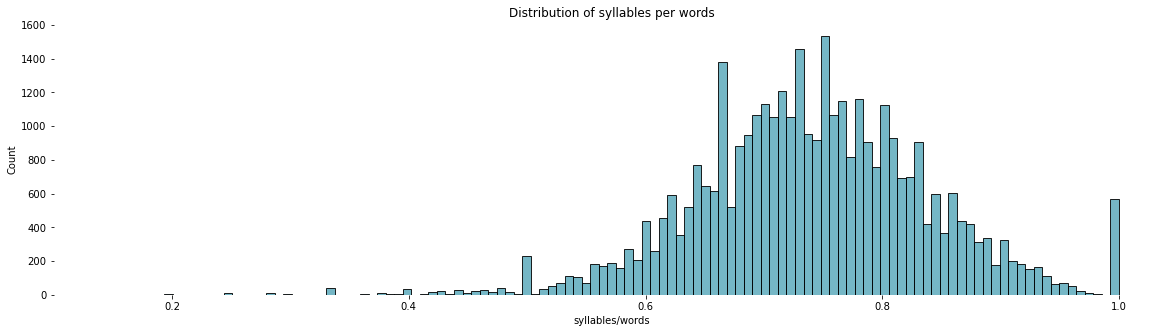

In [72]:
fig = plt.figure(figsize = (20,5))
sns.histplot(train.syll_per_words)
plt.title('Distribution of syllables per words')
plt.xlabel('syllables/words')
plt.ylabel('Count')
plt.box(False)
plt.show()

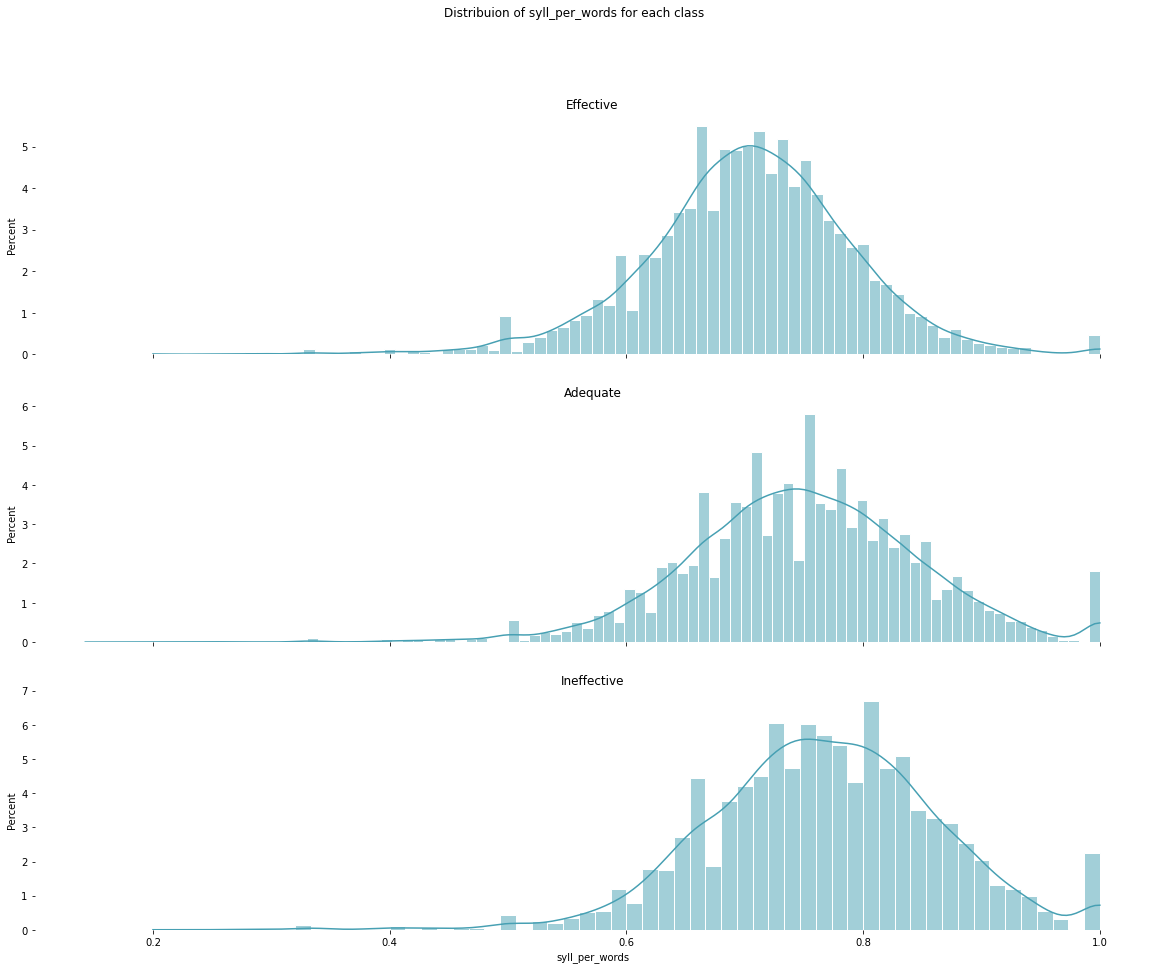

In [73]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (20,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_words, ax = axs[idx], stat = 'percent', kde=True, label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.suptitle('Distribuion of syll_per_words for each class')
plt.show()

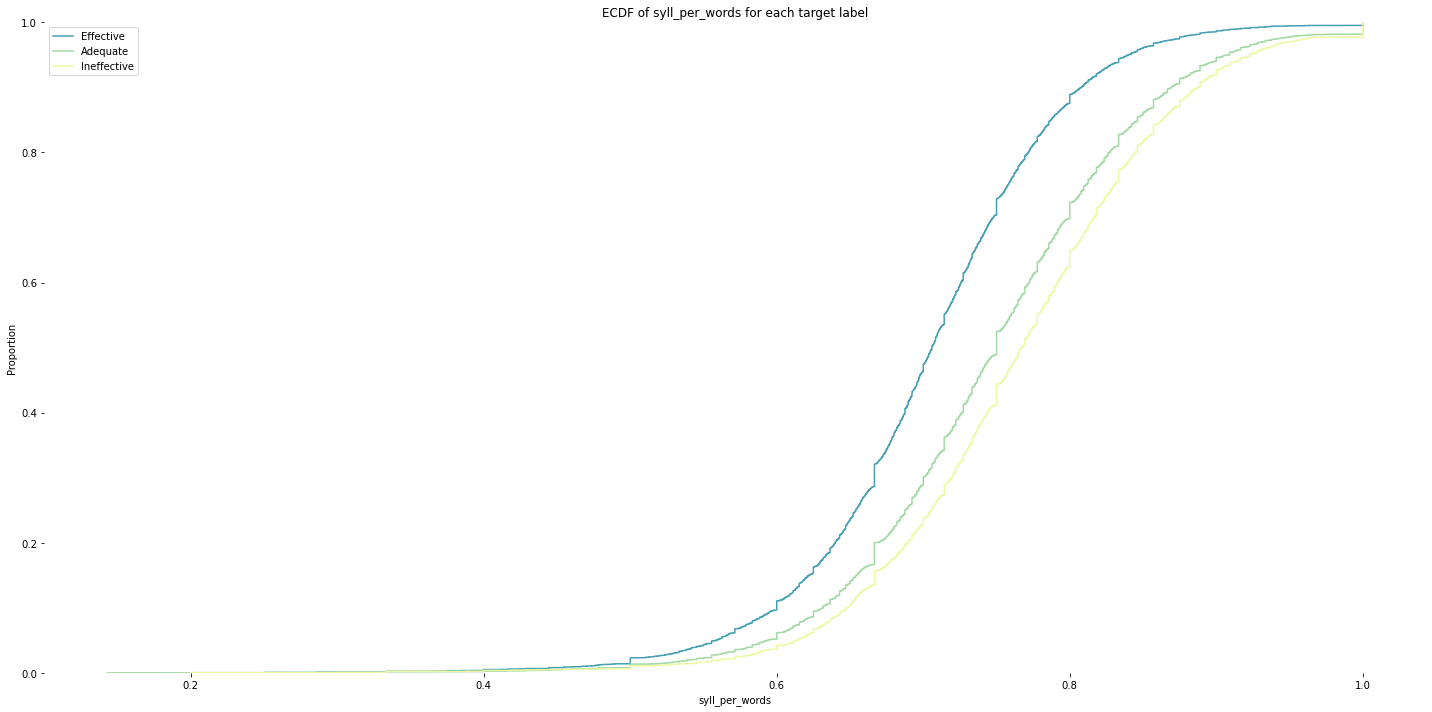

In [74]:
fig = plt.figure(figsize= (20,10))

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.ecdfplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_words, label = eff).set_title(eff)


plt.box(False)
plt.legend()
plt.title("ECDF of syll_per_words for each target label")
plt.tight_layout()
plt.show()

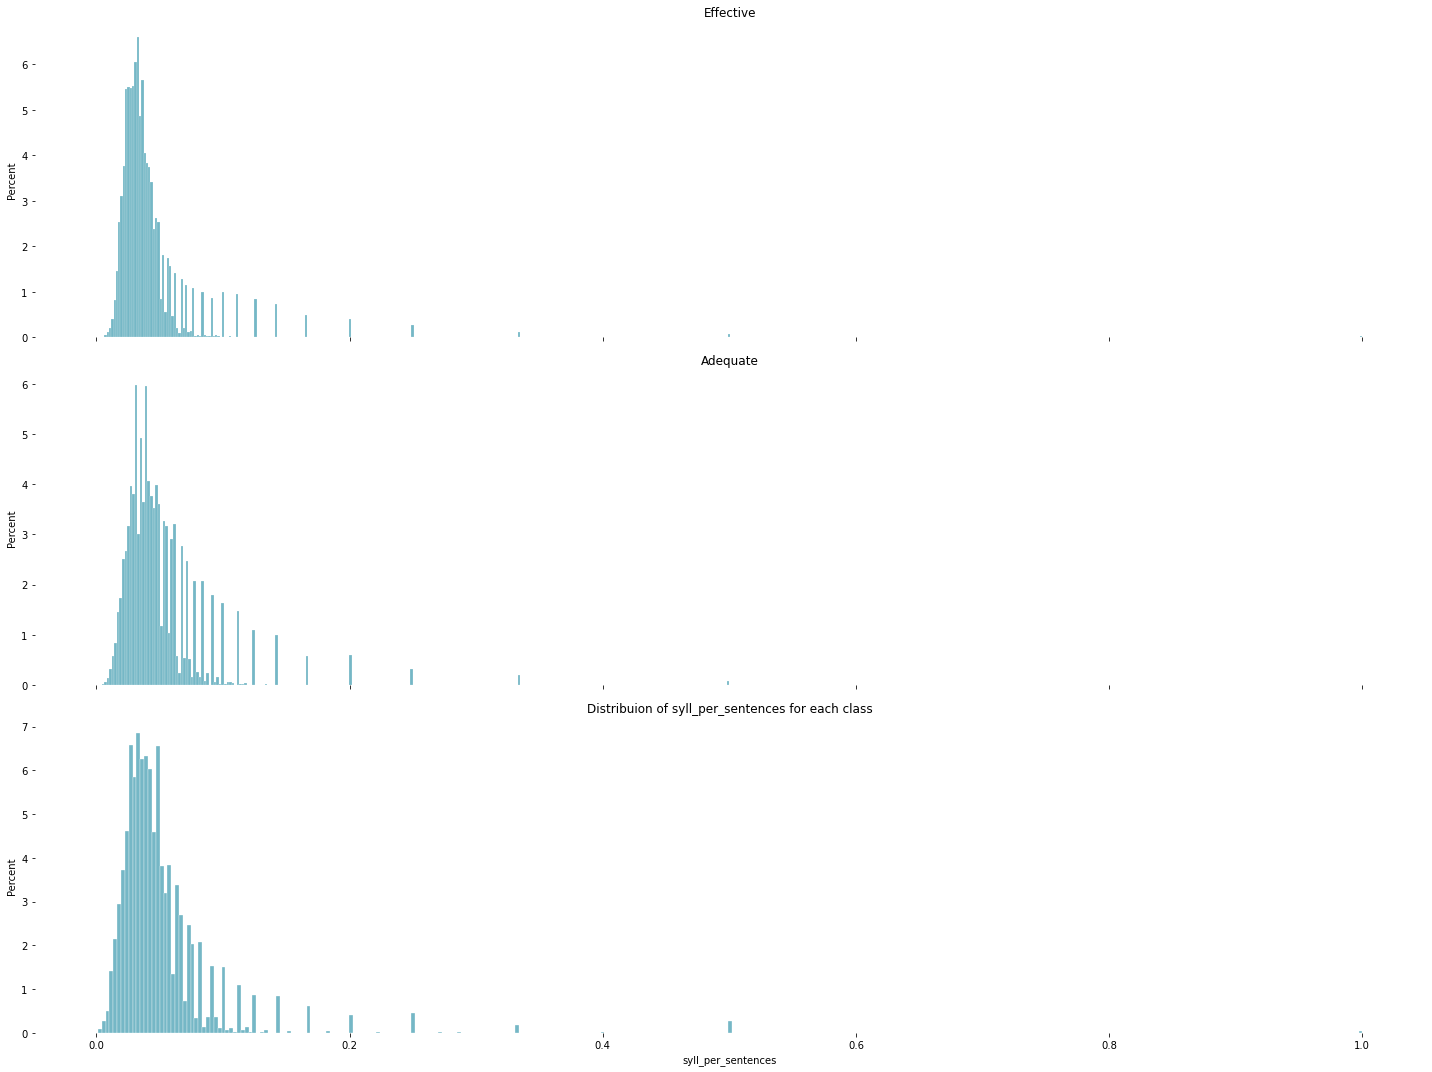

In [75]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (20,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_sentences, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.title('Distribuion of syll_per_sentences for each class')
plt.show()

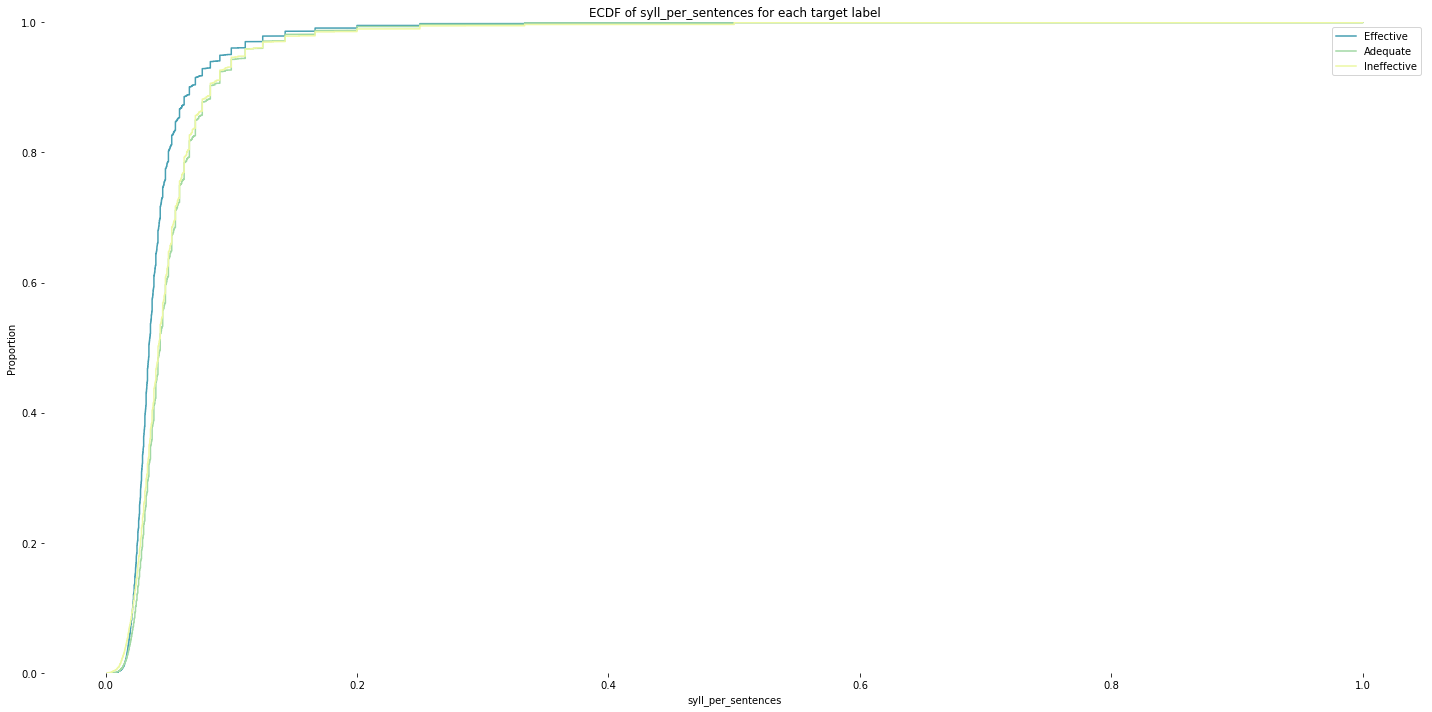

In [76]:
fig = plt.figure(figsize= (20,10))

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.ecdfplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_sentences, label = eff).set_title(eff)
plt.box(False)
plt.legend()
plt.title("ECDF of syll_per_sentences for each target label")
plt.tight_layout()
plt.show()

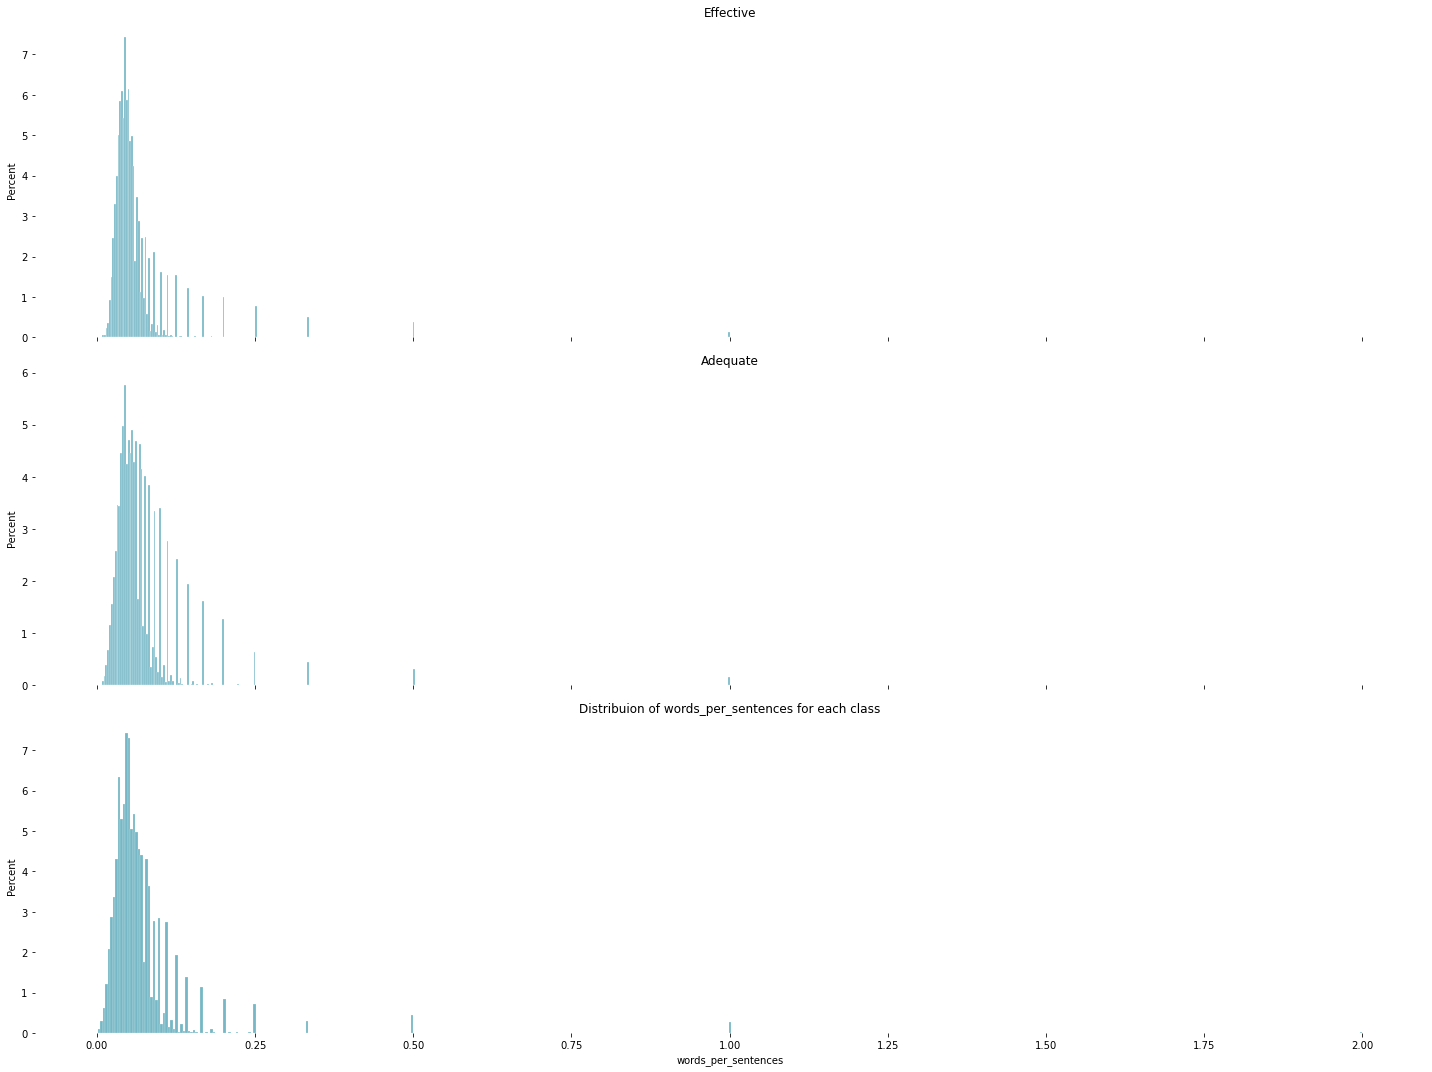

In [77]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (20,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].words_per_sentences, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.title('Distribuion of words_per_sentences for each class')
plt.show()

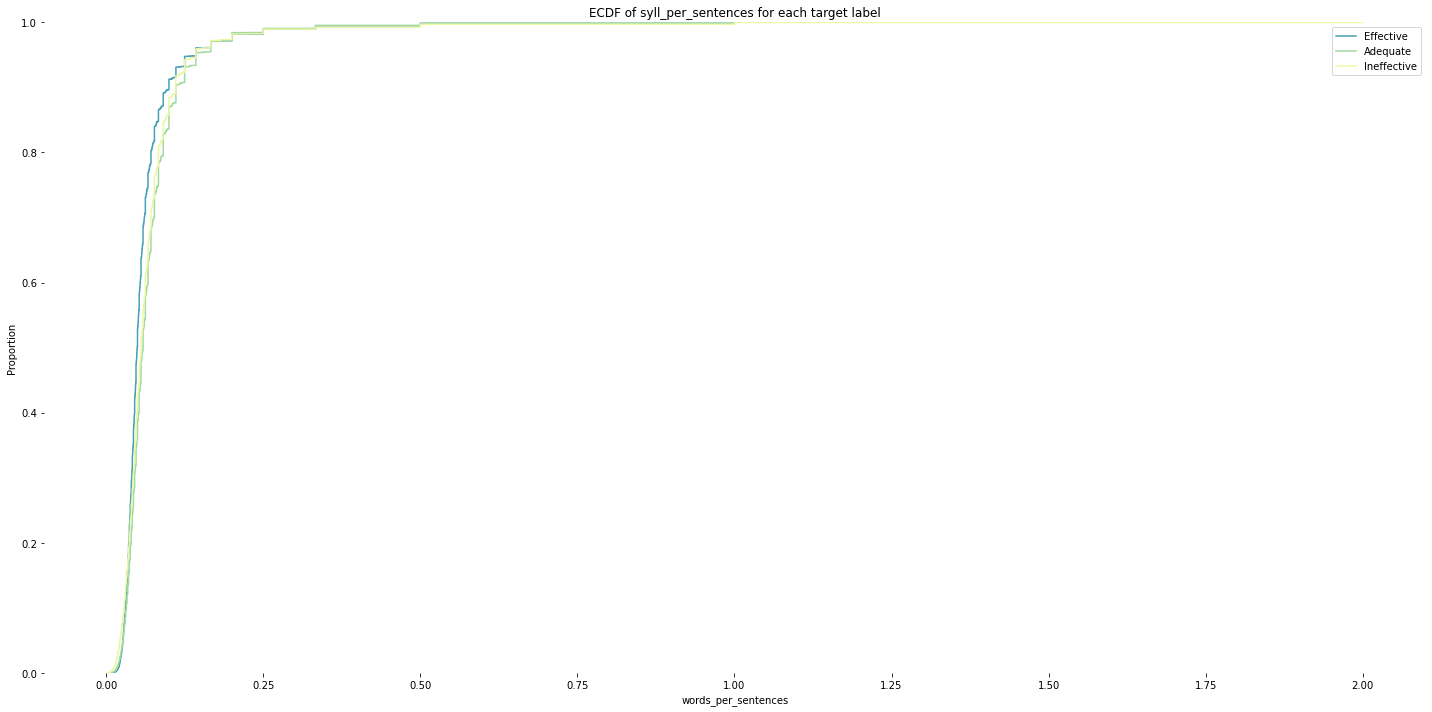

In [78]:
fig = plt.figure(figsize= (20,10))

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.ecdfplot(train[train.loc[:, 'discourse_effectiveness'] == eff].words_per_sentences, label = eff).set_title(eff)
plt.box(False)
plt.legend()
plt.title("ECDF of syll_per_sentences for each target label")
plt.tight_layout()
plt.show()

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from category_encoders import OneHotEncoder
from scipy import sparse
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, confusion_matrix

In [80]:
target_labels_mapping = {"Ineffective": 0, "Adequate":1, "Effective":2}
reversed_target_label = {str(value): key for key, value, in target_labels_mapping.items()}
X, Y = train.drop('discourse_effectiveness', axis=1, inplace = False), train.discourse_effectiveness

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state=RANDOM_SEED, stratify=train.discourse_effectiveness)
Y_train = Y_train.map(target_labels_mapping)
Y_test = Y_test.map(target_labels_mapping)


In [81]:
x_train = X_train
y_train = Y_train.to_numpy()

x_valid = X_test
y_valid = Y_test.to_numpy()

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train.essay_text.drop_duplicates())

vectorized_discourse_text_train = vectorizer.transform(x_train.discourse_text)
vectorized_discourse_text_test = vectorizer.transform(x_valid.discourse_text)

ohe = OneHotEncoder()
ohe_discourse_type_train = ohe.fit_transform(x_train.discourse_type.values.reshape(-1, 1))
ohe_discourse_type_test = ohe.transform(x_valid.discourse_type.values.reshape(-1, 1))

x_train = sparse.hstack([vectorized_discourse_text_train, ohe_discourse_type_train])
x_valid = sparse.hstack([vectorized_discourse_text_test, ohe_discourse_type_test])

# In case it is necessary
# scaler = MaxAbsScaler()
# x_train = scaler.fit_transform(x_train)
# x_valid = scaler.transform(x_valid)

model = XGBClassifier()
model.fit(x_train, y_train)
actual_pred = model.predict(x_valid)
prob_predictions = model.predict_proba(x_valid)
lloss = log_loss(y_valid, prob_predictions)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:56:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	Log loss: 0.7732808567926347
	Accuracy: 0.6580987352101183
	MCC: 0.3506648165716173
................................................................................


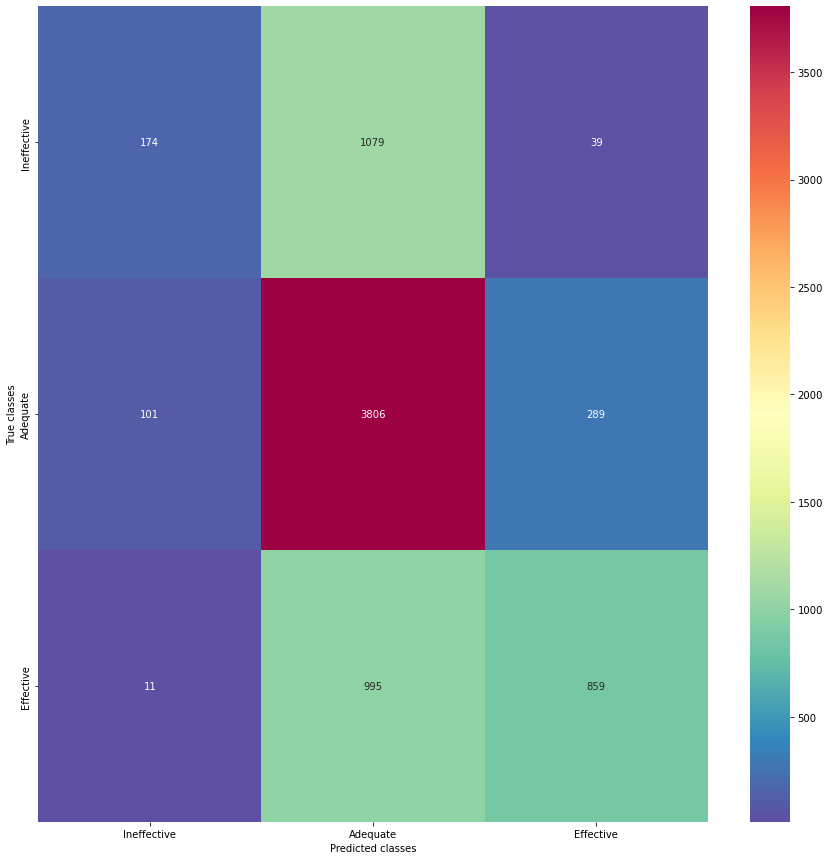

In [82]:

cfm = confusion_matrix(y_true = y_valid, y_pred = actual_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cfm, annot = True, fmt = '.0f', cmap = 'Spectral_r', xticklabels=target_labels_mapping.keys(), yticklabels=target_labels_mapping.keys())
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks()

print(f"\tLog loss: {lloss}")
print(f"\tAccuracy: {accuracy_score(y_valid, actual_pred)}")
print(f"\tMCC: {matthews_corrcoef(y_valid, actual_pred)}")
print(80*'.')

	Log loss: 0.7732808567926347
	Accuracy: 0.6580987352101183
	MCC: 0.3506648165716173
................................................................................


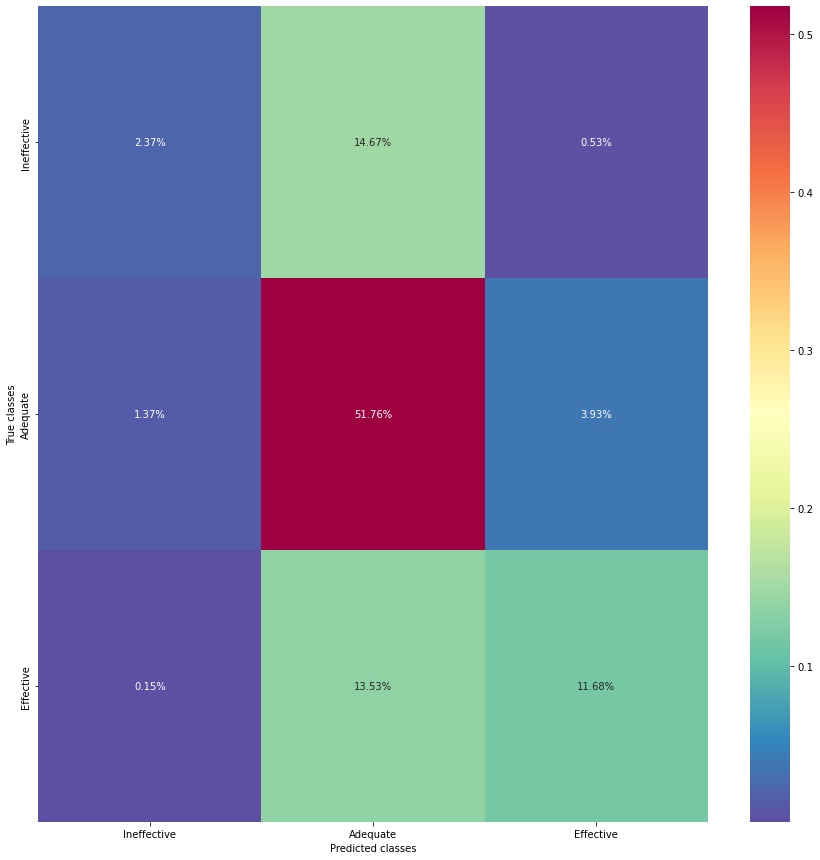

In [83]:

cfm = confusion_matrix(y_true = y_valid, y_pred = actual_pred) / len(y_valid)

plt.figure(figsize=(15,15))
sns.heatmap(cfm, annot = True, fmt = '.2%', cmap = 'Spectral_r', xticklabels=target_labels_mapping.keys(), yticklabels=target_labels_mapping.keys())
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks()

print(f"\tLog loss: {lloss}")
print(f"\tAccuracy: {accuracy_score(y_valid, actual_pred)}")
print(f"\tMCC: {matthews_corrcoef(y_valid, actual_pred)}")
print(80*'.')

In [84]:
predictions = pd.DataFrame(
    {
        'true_labels' : y_valid, 
        'predicted_labels': actual_pred
    }
)

In [85]:
good_predictions = predictions.loc[predictions.true_labels == predictions.predicted_labels].index
good_predictions

Int64Index([   0,    1,    3,    4,    6,    7,    9,   11,   12,   16,
            ...
            7338, 7341, 7342, 7344, 7345, 7346, 7348, 7349, 7351, 7352],
           dtype='int64', length=4839)

In [86]:
print(f"\n\n Good predictions: ")
for row_idx, prediction in X_test.iloc[good_predictions].sample(10).iterrows():
    
    print()
    print(f"\t{Y.iloc[row_idx]}")
    print(f"\t{prediction.discourse_text}")


    print(f"\t{80*'-'}")
    print()




 Good predictions: 

	Adequate
	Dear senator I am arguing to you in favor of keeping the Electoral College for the voting process of the president. 
	--------------------------------------------------------------------------------


	Adequate
	Venus sometimes is called the "Evenning Star." Its one of the highest points of light on the sky. Venus is actually a planet and not a star. Venus is the closeest planet to earth such as its density, size, and sometimes distance too. 
	--------------------------------------------------------------------------------


	Adequate
	People drop out of school cause they think if they don't have the grades to play sports they cant do anything with their life. So i know you don't want that to happen 
	--------------------------------------------------------------------------------


	Adequate
	If we get rid of the Electoral College then we won't have to deal with people stressing about the candidate who should've won and the candidate who actually won.

In [87]:
ineffective_insteadof_adequate = predictions.loc[(predictions.true_labels == 0) & (predictions.predicted_labels == 1)]
ineffective_insteadof_adequate

,true_labels,predicted_labels
13,0,1
21,0,1
24,0,1
25,0,1
27,0,1
...,...,...
7328,0,1
7331,0,1
7337,0,1
7343,0,1


In [88]:
print(f"\n\n Predicted 'Adequate', \n True label 'Ineffective' ")
print(f" Count {len(X_test.iloc[ineffective_insteadof_adequate.index])}")
for row_idx, prediction in X_test.iloc[ineffective_insteadof_adequate.index].sample(25).iterrows():
    
    print()
    print(f"\t{prediction.discourse_text}")


    print(f"\t{80*'-'}")
    print()



 Predicted 'Adequate', 
 True label 'Ineffective' 
 Count 1079

	im not sure how may people would buy themi would not like not being in controll of what my car is doing . 
	--------------------------------------------------------------------------------


	but sometimes it is important to learn about ur emotions even if we don't want to because sometimes we could use the work of why we use so much emotions when we talk to people or even taking the trash out we all still use emotions but why do we. 
	--------------------------------------------------------------------------------


	Only classes are a good reason to use because is a good way to cominitate in a long distance 
	--------------------------------------------------------------------------------


	For the muscle and painting part of the passage. I think it had no relavents to the main idea of emotion based pop ups 
	--------------------------------------------------------------------------------


	Like I said it is unfair,

In [89]:
adequate_insteadof_effective = predictions.loc[(predictions.true_labels == 2) & (predictions.predicted_labels == 1)]
adequate_insteadof_effective

,true_labels,predicted_labels
2,2,1
8,2,1
10,2,1
15,2,1
34,2,1
...,...,...
7333,2,1
7336,2,1
7339,2,1
7340,2,1


In [90]:
print(f"\n\n Predicted 'Adequate', \n True label 'Effective': ")
print(f" Count {len(X_test.iloc[adequate_insteadof_effective.index])}")

for row_idx, prediction in X_test.iloc[adequate_insteadof_effective.index].sample(25).iterrows():
    
    print()
    print(f"\t{prediction.discourse_text}")


    print(f"\t{80*'-'}")
    print()



 Predicted 'Adequate', 
 True label 'Effective': 
 Count 995

	If the teachers can read their expressions, change their lesson plan, and create a greatly improved learning environment, then everyone can go home happy. 
	--------------------------------------------------------------------------------


	many students have trouble focusing when around many other students. 
	--------------------------------------------------------------------------------


	The elector college is a controversial subject today in america, based on many questionable policies that leave many americans confused and cheated. 
	--------------------------------------------------------------------------------


	asking many people what they would do in the same scenario might tell you there might be a clear majority leaning towards one side of the choice. 
	--------------------------------------------------------------------------------


	We need to help them understand that the only way things are going to ch

In [91]:
X.loc[X.discourse_text.str.contains('so I')]

,discourse_id,essay_id,discourse_text,discourse_type,essay_text,text_,tokenized_sentences,correct_list,incorrect_indices,incorrect_words,...,relative_position,sentences,words,syllables,sent_count,word_count,syll_count,words_per_sentences,syll_per_sentences,syll_per_words
590,0b5aba2c95e3,0C8E8861F91A,"In a whole, this is a lot to disagree with, si...",Concluding Statement,I agree with the claim against the value of us...,"In a whole, this is a lot to disagree with, si...","[In, a, whole, ,, this, is, a, lot, to, disagr...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[82],[themotional],...,"(0.2798701298701299, 1)","[In a whole, this is a lot to disagree with, s...","[In, a, whole, this, is, a, lot, to, disagree,...","[In, a, whole, this, is, a, lot, to, dis, agre...",3,77,107,0.038961,0.028037,0.719626
840,8cab1a20ad9d,1006FE578078,Students graduating shouldn't be decided by if...,Concluding Statement,Making extracurricular activities mandatory fo...,Students graduating should not be decided by i...,"[Students, graduating, should, not, be, decide...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],...,"(0.8741914618369987, 0.9925614489003881)",[Students graduating shouldn't be decided by i...,"[Students, graduating, should, n't, be, decide...","[Stu, dents, grad, u, at, ing, should, n't, be...",1,63,99,0.015873,0.010101,0.636364
1738,22710b811e88,2017D32A0639,The point of a summer assignment is to prevent...,Evidence,Many schools across the country require studen...,The point of a summer assignment is to prevent...,"[The, point, of, a, summer, assignment, is, to...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[52, 202]","[shouldn', problthems]",...,"(0.32727920227920226, 0.8283475783475783)",[The point of a summer assignment is to preven...,"[The, point, of, a, summer, assignment, is, to...","[The, point, of, a, sum, mer, as, sign, ment, ...",13,259,350,0.050193,0.037143,0.740000
2488,d7da98659b61,2D644290FFF5,venus is also named after a strip club but any...,Evidence,Studying venus is wrothy pursuit despite the d...,venus is also named after a strip club but any...,"[venus, is, also, named, after, a, strip, club...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 16, 31, 45, 58, 61, 68, 69, 73, 76, 86, 87...","[venus, 'evening, .Venus, twin'.A, sulfric, ve...",...,"(0.9413067552602437, 1)",[venus is also named after a strip club but an...,"[venus, is, also, named, after, a, strip, club...","[venus, is, also, named, af, ter, a, strip, cl...",1,151,207,0.006623,0.004831,0.729469
2560,a02f0bf9fce1,2E57A0350FFD,I love being able to go out on the sea and hav...,Evidence,Being a seagoing cowboy was much more than adv...,I love being able to go out on the sea and hav...,"[I, love, being, able, to, go, out, on, the, s...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[14, 18, 45, 72, 99, 130, 147, 155, 179, 188, ...","[helpping, problthems, war11, problthems, thth...",...,"(0.01933873986275733, 0.7669993761696818)",[I love being able to go out on the sea and ha...,"[I, love, being, able, to, go, out, on, the, s...","[I, love, be, ing, able, to, go, out, on, the,...",22,526,609,0.041825,0.036125,0.863711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36336,b1c407e493d2,E0B1630FB93C,By gaining a different viewpoint of the decisi...,Evidence,Gathering multiple opinions helps people make ...,By gaining a different viewpoint of the decisi...,"[By, gaining, a, different, viewpoint, of, the...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[43, 74, 129, 137, 139, 146, 184]","[Generic_School, Generic_School, ``, Generic_S...",...,"(0.3751328374070138, 0.655951115834219)",[By gaining a different viewpoint of the decis...,"[By, gaining, a, different, viewpoint, of, the...","[By, gain, ing, a, dif, fer, ent, view, point,...",10,199,270,0.050251,0.037037,0.737037
36338,23349ff835db,E0B1630FB93C,"If you ask someone for advice, they may be abl...",Evidence,G

#### POS

In [92]:
import spacy
nlp = spacy.load('en_core_web_lg', disable=['lemmatizer', 'tok2vec'])

2022-08-23 00:56:33.129603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 00:56:33.164443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-23 00:56:33.164457: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [93]:
#### This should be replaced by a pipe, for faster processing

def extract_features(text):
    doc = nlp(text)
    tokens_ = []
    poss_ = []
    tags_ = []
    morphs_ = []

    for token in doc:
        tokens_.append(token.text)
        poss_.append(token.pos_)
        tags_.append(token.tag_)
        morphs_.append(token.morph)

    return (tokens_, poss_, tags_, morphs_)
    

In [94]:
train['discourse_features_all'] = train.discourse_text.map(extract_features)
train['essay_features_all'] =  train.essay_text.map(extract_features)

In [95]:
t_features = train.discourse_features_all.apply(pd.Series)
t_features.columns = ['discourse_tokens', 'discourse_pos', 'discourse_tag', 'discourse_morph']

e_features = train.essay_features_all.apply(pd.Series)
e_features.columns = ['essay_tokens', 'essay_pos', 'essay_tag', 'essay_morph']

train = pd.concat([train, t_features, e_features], axis = 1)

In [96]:
train.drop('discourse_features_all', axis = 1, inplace = True)
train.drop('essay_features_all', axis = 1, inplace = True)

<AxesSubplot:ylabel='Percent'>

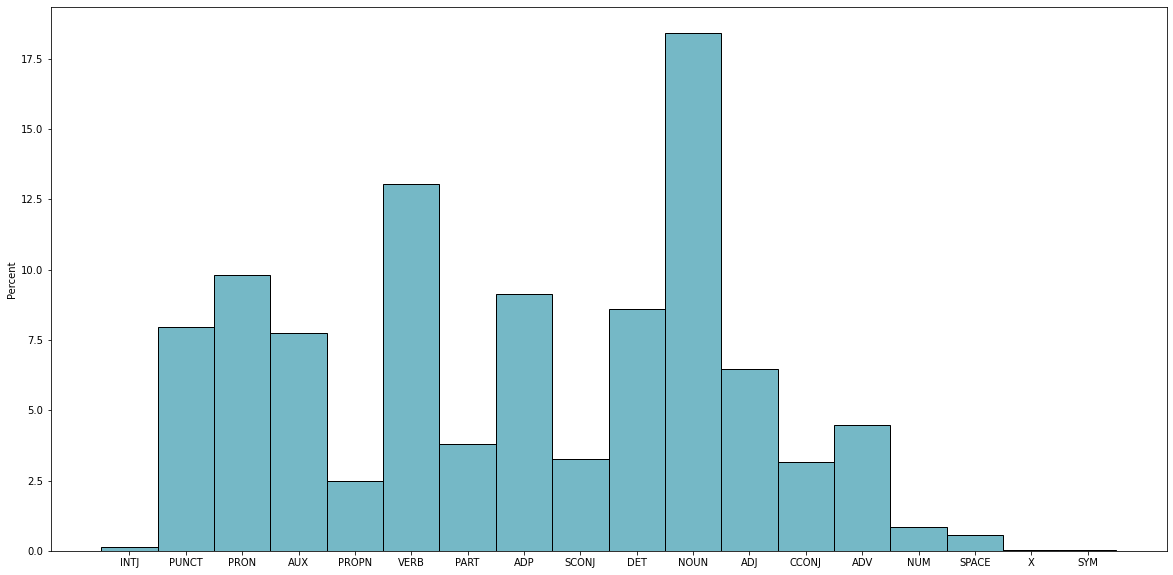

In [97]:
fig = plt.figure(figsize= (20,10))
pos_list = list(chain(*train.discourse_pos))
sns.histplot(pos_list, stat = 'percent')

In [98]:
pos_vectorizer = TfidfVectorizer(ngram_range=(1,4))

In [99]:
X, Y = train.drop('discourse_effectiveness', axis=1, inplace = False), train.discourse_effectiveness

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state=RANDOM_SEED, stratify=train.discourse_effectiveness)

pos_features_train = pos_vectorizer.fit_transform(X_train.discourse_pos.map(' '.join))
pos_features_test = pos_vectorizer.transform(X_test.discourse_pos.map(' '.join))

Y_train = Y_train.map(target_labels_mapping).to_numpy()
Y_test = Y_test.map(target_labels_mapping).to_numpy()

In [100]:
ohe = OneHotEncoder()
ohe_discourse_type_train = ohe.fit_transform(X_train.discourse_type.values.reshape(-1, 1))
ohe_discourse_type_test = ohe.transform(X_test.discourse_type.values.reshape(-1, 1))

x_train = sparse.hstack([pos_features_train, ohe_discourse_type_train])
x_valid = sparse.hstack([pos_features_test, ohe_discourse_type_test])
y_train = Y_train
y_valid = Y_test


model = XGBClassifier()
model.fit(x_train, y_train)
actual_pred = model.predict(x_valid)
prob_predictions = model.predict_proba(x_valid)
lloss = log_loss(y_valid, prob_predictions)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:15:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	Log loss: 0.8101103732650665
	Accuracy: 0.6401468788249693
	MCC: 0.30953464344868753
................................................................................


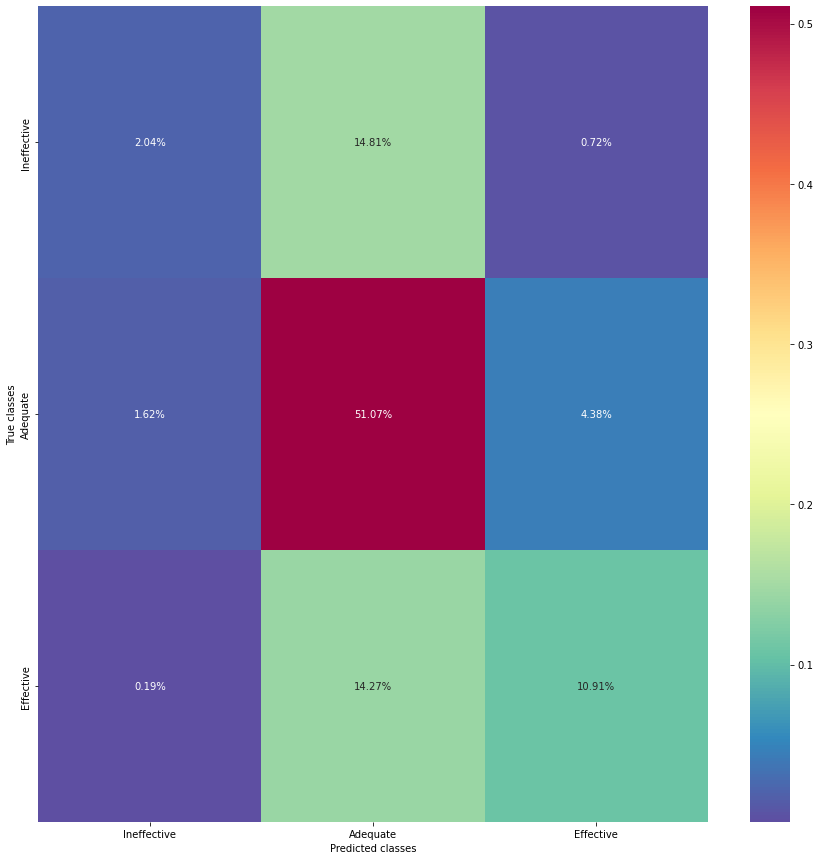

In [101]:
cfm = confusion_matrix(y_true = y_valid, y_pred = actual_pred) / len(y_valid)

plt.figure(figsize=(15,15))
sns.heatmap(cfm, annot = True, fmt = '.2%', cmap = 'Spectral_r', xticklabels=target_labels_mapping.keys(), yticklabels=target_labels_mapping.keys())
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks()

print(f"\tLog loss: {lloss}")
print(f"\tAccuracy: {accuracy_score(y_valid, actual_pred)}")
print(f"\tMCC: {matthews_corrcoef(y_valid, actual_pred)}")
print(80*'.')

#### Questions 

In [102]:
train['contains_question'] = train.discourse_text.str.contains('\?').astype(int)

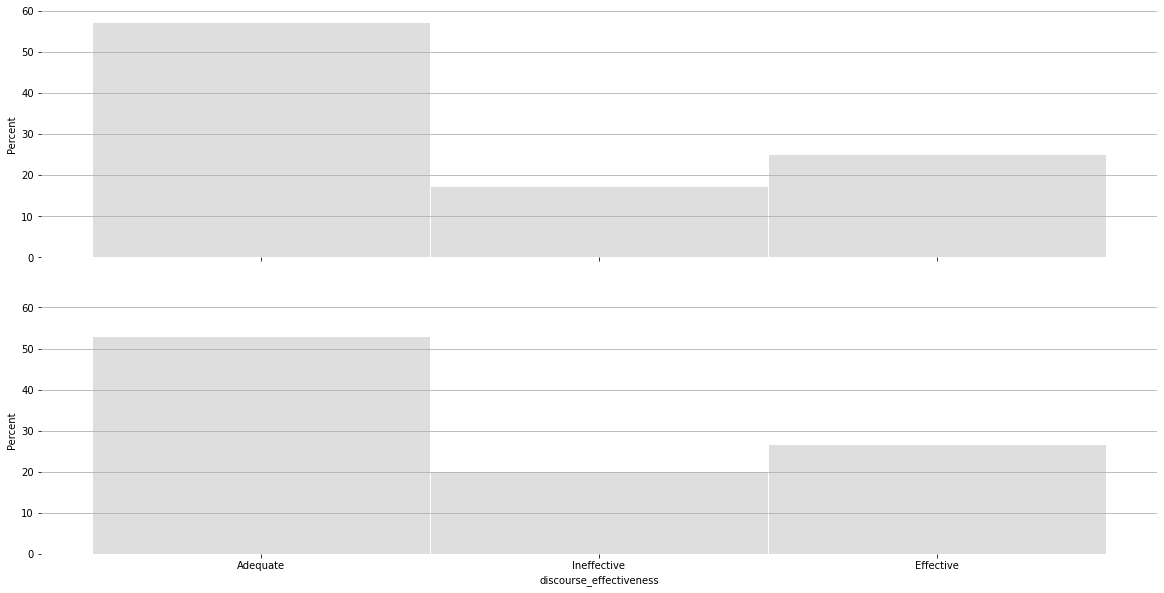

In [136]:
fig, axs = plt.subplots(2, 1, figsize = (20,10), sharex = True, sharey=True)

subset_0 = train.loc[train.contains_question == 0].discourse_effectiveness
subset_1 = train.loc[train.contains_question == 1].discourse_effectiveness

sns.histplot(subset_0, stat = 'percent', color = 'lightgray', ax = axs[0], edgecolor = 'white')
sns.histplot(subset_1, stat = 'percent', color = 'lightgray', ax = axs[1], edgecolor = 'white')


axs[0].grid(which = 'major', axis = 'y')
axs[1].grid(which = 'major', axis = 'y')
axs[0].set_frame_on(False)
axs[1].set_frame_on(False)




#### Verb tempus

In [147]:
sample = train.essay_morph.iloc[0]

In [156]:
for i in sample:
    print(i.to_dict())

{}
{'PunctType': 'Comm'}
{'Case': 'Nom', 'Number': 'Sing', 'Person': '1', 'PronType': 'Prs'}
{'Mood': 'Ind', 'Number': 'Sing', 'Person': '1', 'Tense': 'Pres', 'VerbForm': 'Fin'}
{'Number': 'Sing'}
{'PunctType': 'Comm'}
{'Case': 'Nom', 'Number': 'Sing', 'Person': '1', 'PronType': 'Prs'}
{'Mood': 'Ind', 'Number': 'Sing', 'Person': '1', 'Tense': 'Pres', 'VerbForm': 'Fin'}
{'Aspect': 'Prog', 'Tense': 'Pres', 'VerbForm': 'Part'}
{}
{'VerbForm': 'Inf'}
{'Aspect': 'Prog', 'Tense': 'Pres', 'VerbForm': 'Part'}
{}
{}
{'Number': 'Sing', 'PronType': 'Dem'}
{'Number': 'Sing'}
{}
{'Number': 'Sing'}
{'Mood': 'Ind', 'Number': 'Sing', 'Person': '3', 'Tense': 'Pres', 'VerbForm': 'Fin'}
{'Definite': 'Ind', 'PronType': 'Art'}
{'Degree': 'Pos'}
{'Number': 'Sing'}
{'ConjType': 'Cmp'}
{}
{}
{'Mood': 'Ind', 'Number': 'Sing', 'Person': '3', 'Tense': 'Pres', 'VerbForm': 'Fin'}
{'Number': 'Sing'}
{}
{'Number': 'Sing'}
{'PronType': 'Rel'}
{'Tense': 'Past', 'VerbForm': 'Fin'}
{'Case': 'Acc', 'Gender': 'Neut', 'Num

In [157]:
train.incorrect_words_len

0        0
1        1
2        1
3        3
4        1
        ..
36760    0
36761    0
36762    0
36763    1
36764    0
Name: incorrect_words_len, Length: 36765, dtype: int64